
# FINM 33150 - Regression Analysis and Quantitative Trading Strategies

# Homework: Financial Ratio Quantile Strategies

In [1]:
# Jupyter notebook setup
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import describe
from scipy.stats import norm
import quandl
import functools
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os, sys
pd.set_option('precision', 6)

In [2]:
# Quandl fetch data set up
quandl.ApiConfig.api_key = 'XXXXXXX'

try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(database, securities, start_date, end_date):
        print('fetching data')
        data = quandl.get_table(database, ticker=list(securities), date={"gte":start_date, "lte":end_date}, paginate=True)
        return data
    print("fetch_quandl has now been defined")

fetch_quandl has now been defined


### Define global variables

In [3]:
# Start and end date for testing
start_date = '2014-01-01'
end_date = '2021-01-31'

# Start date for fetching fundamental data
#   We have to fetch fundamental data up to a year prior of our testing dates to calculate ratios
report_start_date = '2013-01-01' #
EOD_db = 'QUOTEMEDIA/PRICES'

# Q1 Understand Your Data

## Import Data
### We can extract data from Quandl using the following URLs:
#### FC: https://data.nasdaq.com/tables/ZACKS-FC/export?api_key=gw5ynDNFtz-xUxxxznmY
#### FR: https://data.nasdaq.com/tables/ZACKS-FR/export?api_key=gw5ynDNFtz-xUxxxznmY
#### MT: https://data.nasdaq.com/tables/ZACKS-MT/export?api_key=gw5ynDNFtz-xUxxxznmY
#### MKTV: https://data.nasdaq.com/tables/ZACKS-MKTV/export?api_key=gw5ynDNFtz-xUxxxznmY
#### SHRS: https://data.nasdaq.com/tables/ZACKS-SHRS/export?api_key=gw5ynDNFtz-xUxxxznmY
#### HDM: https://data.nasdaq.com/tables/ZACKS-HDM/export?api_key=gw5ynDNFtz-xUxxxznmY
#### EOD Data: https://data.nasdaq.com/tables/QUOTEMEDIA-PRICES/export?api_key=gw5ynDNFtz-xUxxxznmY

In [4]:
# Import necessary data for quantile trading simulation
FC = pd.read_csv('ZACKS_FC.csv', parse_dates=['per_end_date', 'filing_date'])

FR = pd.read_csv('ZACKS_FR.csv', parse_dates=['per_end_date'])

MT = pd.read_csv('ZACKS_MT.csv')

MKTV = pd.read_csv('ZACKS_MKTV.csv', parse_dates=['per_end_date'])

SHRS = pd.read_csv('ZACKS_SHRS.csv', parse_dates=['per_end_date'])

HDM = pd.read_csv('ZACKS_HDM.csv')

EOD = pd.read_csv('QUOTEMEDIA_PRICES.csv', parse_dates=['date'])
EOD = EOD.loc[(EOD['date']>=report_start_date) & (EOD['date']<=end_date), ['date', 'ticker', 'adj_close']]

ted = quandl.get("FRED/TEDRATE")
T3M = quandl.get("FRED/DTB3")
repo = pd.DataFrame(columns=['repo'])
# Daily repo rate = T3M + ted - 100bps= LIBOR/SOFR - 100bps
repo['repo_daily'] = ((T3M['Value'] + ted['Value'] - 100)/100)/252

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
FC.head()

m_ticker ticker comp_name    comp_name_2 exchange currency_code  \
0      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
1      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
2      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
3      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
4      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   

  per_end_date per_type  per_code  per_fisc_year  ...  stock_based_compsn_qd  \
0   2006-12-31        A       NaN           2006  ...                    NaN   
1   2007-12-31        A       NaN           2007  ...                    NaN   
2   2008-12-31        A       NaN           2008  ...                    NaN   
3   2009-12-31        A       NaN           2009  ...                    NaN   
4   2010-12-31        A       NaN           2010  ...                    NaN   

   cash_flow_oper_activity_qd  net_change_prop_plant_equip_qd  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

  comm_stock_div_paid_qd pref_stock_div_paid_qd  tot_comm_pref_stock_div_qd  \
0                    NaN                    NaN                         NaN   
1                    NaN                    NaN                         NaN   
2                    NaN                    NaN                         NaN   
3                    NaN                    NaN                         NaN   
4                    NaN                    NaN                         NaN   

   wavg_shares_out  wavg_shares_out_diluted  eps_basic_net  eps_diluted_net  
0              NaN                      NaN            NaN              NaN  
1              NaN                      NaN            NaN              NaN  
2              NaN                      NaN            NaN              NaN  
3              NaN                      NaN            NaN              NaN  
4              NaN                      NaN            NaN              NaN  

[5 rows x 249 columns]

In [6]:
FR.head()

m_ticker ticker comp_name    comp_name_2 exchange currency_code  \
0      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
1      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
2      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
3      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   
4      CPG  3262Q       NaN  CMS ENERGY -G      NaN           USD   

  per_end_date per_type  per_code  per_fisc_year  ...  invty_turn  rcv_turn  \
0   2006-12-31        A       NaN           2006  ...         NaN       NaN   
1   2007-12-31        A       NaN           2007  ...         NaN       NaN   
2   2008-12-31        A       NaN           2008  ...         NaN       NaN   
3   2009-12-31        A       NaN           2009  ...         NaN       NaN   
4   2010-12-31        A       NaN           2010  ...         NaN       NaN   

   day_sale_rcv  ret_equity  ret_tang_equity  ret_asset  ret_invst  \
0           NaN      2.4085           1.3277     0.7184     2.3844   
1           NaN     -0.2536          -0.1624    -0.0851    -0.2411   
2           NaN     -0.1566          -0.0905    -0.0507    -0.1497   
3           NaN     -0.2429          -0.1426    -0.0778    -0.2328   
4           NaN     -0.0653          -0.0375    -0.0209    -0.0627   

   free_cash_flow_per_share  book_val_per_share  oper_cash_flow_per_share  
0                       NaN                 NaN                       NaN  
1                       NaN                 NaN                       NaN  
2                       NaN                 NaN                       NaN  
3                       NaN                 NaN                       NaN  
4                       NaN                 NaN                       NaN  

[5 rows x 40 columns]

In [7]:
MT.head()

m_ticker ticker comp_name      comp_name_2 exchange currency_code  \
0     Z86Z  0425B       NaN         PCA INTL      NaN           NaN   
1     FFFC  1186Q       NaN   FRANKLIN FIRST      NaN           NaN   
2     WSTF  1197Q       NaN  WESTERN FINL CP      NaN           NaN   
3     HBCI  1209Q       NaN         HARMONIA      NaN           NaN   
4     TONE  1352Q       NaN          ONE BCP      NaN           NaN   

  ticker_type active_ticker_flag comp_url  sic_4_code  ... per_end_month_nbr  \
0         NaN                  N      NaN         NaN  ...                 1   
1         NaN                  N      NaN         NaN  ...                12   
2         NaN                  N      NaN         NaN  ...                12   
3         NaN                  N      NaN         NaN  ...                12   
4         NaN                  N      NaN         NaN  ...                12   

   mr_split_date mr_split_factor  comp_cik country_code  country_name  \
0            NaN             NaN       NaN          NaN           NaN   
1            NaN             NaN       NaN          NaN           NaN   
2            NaN             NaN       NaN          NaN           NaN   
3            NaN             NaN       NaN          NaN           NaN   
4            NaN             NaN       NaN          NaN           NaN   

  comp_type  optionable_flag sp500_member_flag  asset_type  
0       NaN              NaN               NaN         NaN  
1       NaN              NaN               NaN         NaN  
2       NaN              NaN               NaN         NaN  
3       NaN              NaN               NaN         NaN  
4       NaN              NaN               NaN         NaN  

[5 rows x 27 columns]

In [8]:
MKTV.head()

ticker m_ticker     comp_name  fye per_type per_end_date active_ticker_flag  \
0      A       A2  AGILENT TECH   10        Q   2021-12-31                  Y   
1      A       A2  AGILENT TECH   10        Q   2021-09-30                  Y   
2      A       A2  AGILENT TECH   10        Q   2021-06-30                  Y   
3      A       A2  AGILENT TECH   10        Q   2021-03-31                  Y   
4      A       A2  AGILENT TECH   10        Q   2020-12-31                  Y   

    mkt_val    ep_val  
0  48214.43  49368.43  
1  47687.90  48987.90  
2  44851.95  46198.95  
3  38739.24  39595.24  
4  36185.58  37028.58

In [9]:
SHRS.head()

ticker m_ticker     comp_name  fye per_type per_end_date active_ticker_flag  \
0      A       A2  AGILENT TECH   10        Q   2021-10-31                  Y   
1      A       A2  AGILENT TECH   10        Q   2021-07-31                  Y   
2      A       A2  AGILENT TECH   10        Q   2021-04-30                  Y   
3      A       A2  AGILENT TECH   10        Q   2021-01-31                  Y   
4      A       A2  AGILENT TECH   10        Q   2020-10-31                  Y   

   shares_out  avg_d_shares  
0      302.72         305.0  
1      302.72         306.0  
2      303.44         307.0  
3      304.70         309.0  
4      308.31         311.0

In [10]:
HDM.head()

action_type m_ticker  status  per_end_month_nbr       comp_name ticker  \
0            5     #UOC       1                  6  UNILENS VISION  UVICF   
1            5     VIAB       1                 12        CBS CORP  VIA.B   
2            6     VIAB       1                 12        CBS CORP    CBS   
3            5     VIA2       1                 12    VIACOM INC-A   VIAW   
4            5     VIAW       1                 12    VIACOM INC-B  VIABW   

  change_txt     ex_date   proc_date  
0      UVICE         NaN  2006-01-03  
1        CBS         NaN  2006-01-03  
2     0.5000  2006-01-03  2006-01-03  
3        VIA         NaN  2006-01-03  
4      VIA.B         NaN  2006-01-03

In [11]:
EOD.head()

date ticker   adj_close
1863 2019-10-02    EBF   17.761154
1864 2019-10-01    EBF   17.770021
1865 2019-09-30    EBF   17.920765
1866 2019-09-27    EBF   17.849827
7245 2013-01-02   ISRL  103.750000

# Q2 Define the Universe

### Requirement 1: end-of-day adjusted closing prices are available , over the entire period Jan 2014 through Jan 2021

In [12]:
EOD_filter = EOD.loc[(EOD['date']>=start_date) & (EOD['date']<=end_date)]
ticker_days = EOD_filter.groupby('ticker')['adj_close'].count()
num_days = ticker_days.max()
ticker1 = ticker_days[ticker_days==num_days].index
len(ticker1)

4411

### Requirement 2: debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2014 through Jan 2021 (preferably more than fleetingly)

In [13]:
debt_market_cap_threshold = 0.1
FR_filter = FR.loc[(FR['per_end_date']>=start_date) & (FR['per_end_date']<=end_date)]
filter2 = FR_filter.groupby(['ticker', 'm_ticker'])['tot_debt_tot_equity'].max()
filter2 = filter2[filter2>=debt_market_cap_threshold]
ticker2 = filter2.index.unique(level='ticker').tolist()
len(ticker2)

8339

### Requirement 3: not in the automotive, financial or insurance sector , over the entire period Jan 2014 through Jan 2021

In [14]:
# Filter out sectors Auto-Tires-Tricks=5, Finance=13
filter_sectors = [5, 13]
# Filter FC per_end_date to be between our range
FC_filter = FC.loc[(FC['per_end_date']>=start_date) & (FC['per_end_date']<=end_date)]
# Tickers that were in the automotive, financial, or insurance sector
excl_tickers = FC_filter[FC_filter['zacks_sector_code'].isin(filter_sectors)]['ticker'].unique()
filter3 = FC_filter[~FC_filter['ticker'].isin(excl_tickers)]
ticker3 = filter3['ticker'].unique().tolist()
len(ticker3)

9380

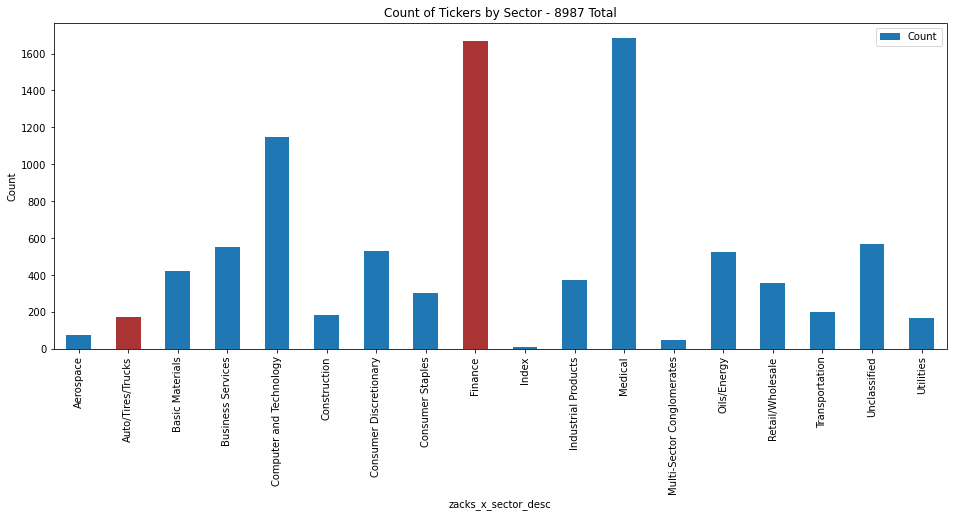

In [15]:
ticker_sector = MT.groupby('zacks_x_sector_desc')['zacks_x_sector_desc'].count().to_frame("Count")
ax = ticker_sector.plot.bar(figsize=(16,6))
ax.set_title('Count of Tickers by Sector - {} Total'.format(ticker_sector['Count'].sum()))
ax.set_ylabel('Count')
ax.patches[1].set_facecolor('#aa3333')
ax.patches[8].set_facecolor('#aa3333')

### Additional Requirements
These are some additional requirements that I have added to reduce of stock universe. While these reductions may not be 100% necessary, it allows for the strategy to perform better and be more consistent, as well as reduce the computing power needed to run simulations

In [17]:
# Traded on NASDAQ or NYSE. The strategy prefers to trade liquid stocks that is listed in US exchanges
accepted_exchanges = ['NASDAQ', 'NYSE']
ticker4 = FC_filter[FC_filter['exchange'].isin(accepted_exchanges)].ticker.unique().tolist()

# Market Capitalization is greater than 200MM - Avoid small cap and iliquid stocks. 
#   The high volatility of these stocks makes it more difficult to assess the performance of our strategies

market_cap_threshold = 300
MKTV_filter = MKTV.loc[(MKTV['per_end_date']>=start_date) & (MKTV['per_end_date']<=end_date)]
filter3 = MKTV_filter.groupby('ticker')['mkt_val'].min() 
filter3 = filter3[filter3>=market_cap_threshold]
ticker5 = filter3.index.unique(level='ticker').tolist()

universe = list(set(ticker1) & set(ticker2) & set(ticker3) & set(ticker4) & set(ticker5))

print("Universe contains {} tickers".format(len(universe)))

Universe contains 1177 tickers


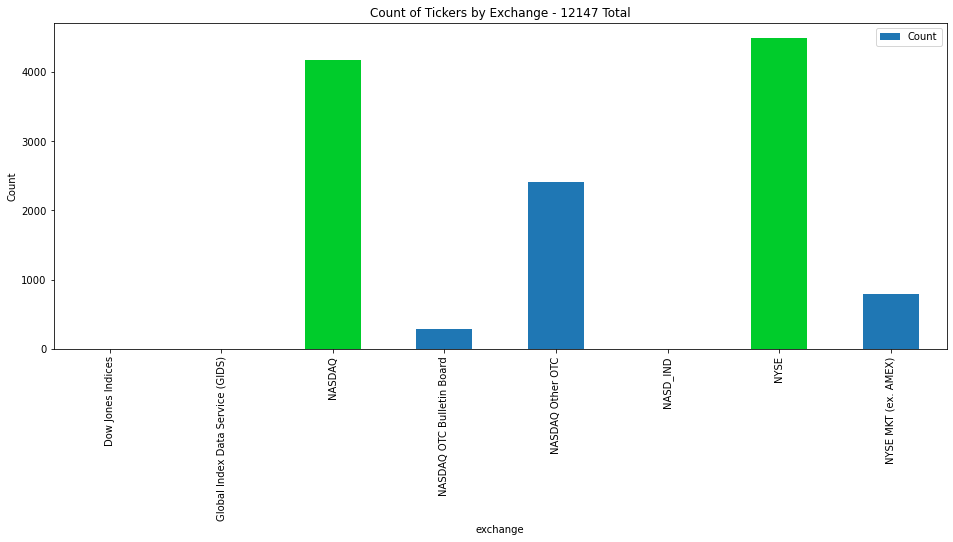

In [18]:
# Visual bar plot to see how many tickers are traded in each exchange
ticker_exchange = MT.groupby('exchange')['exchange'].count().to_frame("Count")
ax = ticker_exchange.plot.bar(figsize=(16,6))
ax.set_title('Count of Tickers by Exchange - {} Total'.format(ticker_exchange['Count'].sum()))
ax.set_ylabel('Count')
ax.patches[2].set_facecolor('#00CC2B')
ax.patches[6].set_facecolor('#00CC2B')

# Q4 Select Financial Ratios

#### Set up dataframe containing all necessary fundamental data

In [19]:
FC_cols = ['per_end_date', 'filing_date', 'ticker', 'per_type', 'net_lterm_debt', 'tot_lterm_debt', 'eps_diluted_net', 'basic_net_eps']
FR_cols = ['per_end_date', 'ticker', 'tot_debt_tot_equity', 'ret_invst']
MKTV_cols = ['per_end_date', 'ticker', 'mkt_val']
SHRS_cols = ['per_end_date', 'ticker', 'shares_out']

# Combine all the tables into one
comb = pd.merge(FC[FC_cols], FR[FR_cols], left_on=['ticker', 'per_end_date'], right_on=['ticker', 'per_end_date'])
comb = pd.merge(comb, MKTV[MKTV_cols], left_on=['ticker', 'per_end_date'], right_on=['ticker', 'per_end_date'])
comb = pd.merge(comb, SHRS[SHRS_cols], left_on=['ticker', 'per_end_date'], right_on=['ticker', 'per_end_date'])

comb = comb[(comb['filing_date'].notna()) & (comb['per_type']=='Q')] # only use quarterly reports

comb.head()

per_end_date filing_date ticker per_type  net_lterm_debt  tot_lterm_debt  \
2    2016-12-31  2017-03-15     AA        Q          1194.0          1424.0   
3    2016-12-31  2017-03-15     AA        Q          1194.0          1424.0   
6    2017-12-31  2018-02-26     AA        Q           -39.0          1388.0   
7    2017-12-31  2018-02-26     AA        Q           -39.0          1388.0   
10   2018-12-31  2019-02-26     AA        Q           425.0          1801.0   

    eps_diluted_net  basic_net_eps  tot_debt_tot_equity  ret_invst  mkt_val  \
2             -0.69          -0.68               0.1877    -3.7934  5136.70   
3             -0.69          -0.68               0.1877    -1.4143  5136.70   
6             -0.72          -1.06               0.2065     7.4273  9976.78   
7             -0.72          -1.06               0.2065    -0.0855  9976.78   
10             0.27           0.23               0.2375     9.5111  4957.01   

    shares_out  
2       182.93  
3       182.93  
6       185.20  
7       185.20  
10      186.49

### Calculate Financial Ratios

In [24]:
all_sec = []

num_dates_ratio_change = 21

for sec in universe:
    
    # Filter for security
    comb_sec = comb[comb['ticker']==sec].copy()
    comb_sec.drop_duplicates(subset=['filing_date'], inplace=True)
    comb_sec.sort_values(by=['per_end_date'], inplace=True)

    # Add in adjust close price on per_end_date
    EOD_sec = EOD[EOD['ticker']==sec].copy()
    EOD_sec.set_index('date', inplace=True)
    EOD_sec.sort_index(inplace=True)
    # Forward fill equity prices to non-trading days (e.g. weekends and holidays)
    EOD_sec = EOD_sec.resample('D').ffill()
    # Join fundamental data and adjusted close price
    comb_sec = pd.merge(comb_sec, EOD_sec[['adj_close']], left_on='per_end_date', right_index=True, how='left')
    comb_sec.rename(columns={'adj_close':'qtr_adj_close'}, inplace=True)
    
    # Forward fill fundamental data to all days 
    comb_sec.sort_values(by=['filing_date'], inplace=True)
    comb_sec = comb_sec.set_index('filing_date').resample('D').ffill()
    
    # Add in adjusted close price for all trading days
    #   Delay fundamental data by one day
    comb_sec = pd.merge(comb_sec.shift(), EOD_sec[['adj_close']], left_index=True, right_index=True, how='inner')
    
    
    ###### Calculate debt to market cap ######
    comb_sec['debt_to_mkt_cap'] = comb_sec['qtr_adj_close'] / comb_sec['adj_close'] * comb_sec['tot_debt_tot_equity']
    comb_sec['debt_to_mkt_cap_diff'] = comb_sec['debt_to_mkt_cap'].diff(num_dates_ratio_change) # Change in debt to mkt cap
    
    ###### Calculate return on investment ######
    # Use net long term debt when available, otherwise use total longterm debt    
    comb_sec['debt'] = comb_sec['net_lterm_debt'].fillna(comb_sec['tot_lterm_debt'])
    comb_sec['mkt_val_daily'] = comb_sec['adj_close'] / comb_sec['qtr_adj_close'] * comb_sec['mkt_val']
    comb_sec['ROI'] = comb_sec['ret_invst'] * (comb_sec['debt'] + comb_sec['mkt_val']) / \
                        (comb_sec['debt'] + comb_sec['mkt_val_daily'])
    comb_sec['ROI_diff'] = comb_sec['ROI'].diff(num_dates_ratio_change) # Change in ROI 
    
    ###### Calculate price to earnings ######
    # Use diluted eps when available, otherwise use basic version eps
    comb_sec['EPS'] = comb_sec['eps_diluted_net'].fillna(comb_sec['basic_net_eps'])
    comb_sec.loc[comb_sec['EPS'] <= 0, 'EPS'] = 0.001 # Change negative or 0 EPS to 0.001
    comb_sec['PE'] = comb_sec['adj_close'] / comb_sec['EPS']
    comb_sec['PE_diff'] = comb_sec['PE'].diff(num_dates_ratio_change) # Change in ROI
    
    all_sec.append(comb_sec)
    
all_sec = pd.concat(all_sec, axis=0)

In [25]:
all_sec.head()

per_end_date ticker per_type  net_lterm_debt  tot_lterm_debt  \
2013-01-02   2012-09-30    PNM        Q             NaN        1672.124   
2013-01-03   2012-09-30    PNM        Q             NaN        1672.124   
2013-01-04   2012-09-30    PNM        Q             NaN        1672.124   
2013-01-05   2012-09-30    PNM        Q             NaN        1672.124   
2013-01-06   2012-09-30    PNM        Q             NaN        1672.124   

            eps_diluted_net  basic_net_eps  tot_debt_tot_equity  ret_invst  \
2013-01-02             0.72           0.73               1.0364     1.8243   
2013-01-03             0.72           0.73               1.0364     1.8243   
2013-01-04             0.72           0.73               1.0364     1.8243   
2013-01-05             0.72           0.73               1.0364     1.8243   
2013-01-06             0.72           0.73               1.0364     1.8243   

            mkt_val  ...  adj_close  debt_to_mkt_cap  debt_to_mkt_cap_diff  \
2013-01-02  1675.12  ...  16.548811              NaN                   NaN   
2013-01-03  1675.12  ...  16.564504              NaN                   NaN   
2013-01-04  1675.12  ...  16.658665              NaN                   NaN   
2013-01-05  1675.12  ...  16.658665              NaN                   NaN   
2013-01-06  1675.12  ...  16.658665              NaN                   NaN   

                debt  mkt_val_daily  ROI  ROI_diff   EPS         PE  PE_diff  
2013-01-02  1672.124            NaN  NaN       NaN  0.72  22.984460      NaN  
2013-01-03  1672.124            NaN  NaN       NaN  0.72  23.006256      NaN  
2013-01-04  1672.124            NaN  NaN       NaN  0.72  23.137035      NaN  
2013-01-05  1672.124            NaN  NaN       NaN  0.72  23.137035      NaN  
2013-01-06  1672.124            NaN  NaN       NaN  0.72  23.137035      NaN  

[5 rows x 22 columns]

#### Set up dataframe containing all necessary ratios for each ticker on each trading day

In [26]:
trading_dates = EOD.loc[(EOD['date'] >= start_date) & (EOD['date'] <= end_date)]['date'].unique()
ratios = all_sec[['ticker', 'debt_to_mkt_cap', 'ROI', 'PE','debt_to_mkt_cap_diff', 'ROI_diff', 'PE_diff']].copy()
ratios = ratios.loc[trading_dates]
ratios.head()

ticker  debt_to_mkt_cap        ROI            PE  \
2019-10-02    PNM         1.808791  -1.624935  48733.479648   
2019-10-02   UTHR         0.403372   6.022057     17.042918   
2019-10-02    TPC         0.661453 -13.282797  13460.000000   
2019-10-02    CMS         2.295504   0.526890    181.305301   
2019-10-02   SMCI         0.328562  13.209644     62.600000   

            debt_to_mkt_cap_diff  ROI_diff      PE_diff  
2019-10-02             -0.053698  0.047039  1405.048078  
2019-10-02              0.017026  0.208347    -0.751073  
2019-10-02             -0.054235  0.836013  1020.000000  
2019-10-02             -0.087323 -0.019249     6.644249  
2019-10-02              0.000000  0.000000     0.000000

#### Requirement 4: Must have feasible calculations of the ratios over the entire period

In [27]:
ROI_valid = ratios.groupby('ticker')[['debt_to_mkt_cap', 'ROI', 'PE']].apply(lambda x: x.notnull().all())

# Take out any securities that cannot calculate ratio on a certain date, so we further refine our universe
universe = ROI_valid[ROI_valid['debt_to_mkt_cap'] & ROI_valid['ROI'] & ROI_valid['PE']].index.tolist()

ratios = ratios[ratios['ticker'].isin(universe)]

print("Universe contains {} tickers".format(len(universe)))

Universe contains 724 tickers


### Correctness Check

In [28]:
ticker_check = 'LLY'
check_dates_per_end = ["2020-06-30", "2020-09-30", "2020-12-31", "2021-03-31", "2021-06-30", '2021-09-30']

check_report = comb.loc[(comb['per_end_date'].isin(check_dates_per_end)) & (comb['ticker']==ticker_check)]
check_report.set_index('per_end_date').sort_index().T

per_end_date                  2020-06-30           2020-09-30  \
filing_date          2020-07-31 00:00:00  2020-10-28 00:00:00   
ticker                               LLY                  LLY   
per_type                               Q                    Q   
net_lterm_debt                     712.3               1786.0   
tot_lterm_debt                   15064.4              16334.6   
eps_diluted_net                     1.55                 1.33   
basic_net_eps                       1.55                 1.33   
tot_debt_tot_equity               3.8221               3.3871   
ret_invst                         7.3023               5.6651   
mkt_val                         157033.3             141593.2   
shares_out                        956.47               956.58   

per_end_date                  2020-12-31           2020-12-31  \
filing_date          2021-02-17 00:00:00  2021-02-17 00:00:00   
ticker                               LLY                  LLY   
per_type                               Q                    Q   
net_lterm_debt                    1785.8               1785.8   
tot_lterm_debt                   16586.6              16586.6   
eps_diluted_net                     2.31                 2.31   
basic_net_eps                       2.32                 2.32   
tot_debt_tot_equity               2.8489               2.8489   
ret_invst                        27.6359                9.445   
mkt_val                        161509.22            161509.22   
shares_out                        956.58               956.58   

per_end_date                  2021-03-31           2021-06-30  \
filing_date          2021-04-30 00:00:00  2021-08-03 00:00:00   
ticker                               LLY                  LLY   
per_type                               Q                    Q   
net_lterm_debt                       NaN                  NaN   
tot_lterm_debt                   16199.6              14736.6   
eps_diluted_net                     1.49                 1.53   
basic_net_eps                       1.49                 1.53   
tot_debt_tot_equity               2.2825               2.4784   
ret_invst                          5.817               6.4962   
mkt_val                        179165.14            220115.53   
shares_out                        959.03               959.03   

per_end_date                  2021-09-30  
filing_date          2021-10-27 00:00:00  
ticker                               LLY  
per_type                               Q  
net_lterm_debt                     505.5  
tot_lterm_debt                   15522.4  
eps_diluted_net                     1.22  
basic_net_eps                       1.22  
tot_debt_tot_equity                2.148  
ret_invst                         4.7286  
mkt_val                        221020.67  
shares_out                        956.59

In [29]:
# Check if my ratio matches the table
#  Check first and last 5 dates
check_dates_ratio = ['2019-10-25', '2019-10-28', '2019-12-31', '2020-01-02', '2020-02-19',
               '2020-10-01', '2020-10-28', '2020-10-29', '2020-12-31']

ticker_check = 'LLY'

check_ratio = ratios.loc[ratios.index.isin(check_dates_ratio) & (ratios['ticker']==ticker_check), \
                         ['debt_to_mkt_cap', 'ROI', 'PE']]

check_ratio.head(20)

debt_to_mkt_cap       ROI          PE
2019-10-25         5.554480  8.048674   73.467766
2019-10-28         4.352354  7.249701   79.176659
2019-12-31         3.720165  6.227653   92.631604
2020-01-02         3.698217  6.191987   93.181347
2020-02-19         3.453830  5.794008   99.774689
2020-10-01         4.327682  8.263302   91.223235
2020-10-28         4.755473  9.075546   83.017001
2020-10-29         3.782411  6.317094   97.662767
2020-12-31         2.953930  4.948484  125.053966

Both the SEC report and ratios match with 6.0.1 and 6.0.2.

# Q5 Analysis

In [30]:
# Create time series dataframe for returns of each stock
returns = EOD.loc[EOD['ticker'].isin(universe) & EOD['date'].isin(trading_dates), ['ticker', 'date', 'adj_close']]
returns = returns.set_index(['date', 'ticker']).unstack().droplevel(level=0, axis=1).pct_change()
returns = returns[universe]
returns.head()

ticker           AAL       AAP      AAPL      AAWW      ABBV       ABC  \
date                                                                     
2014-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2014-01-03  0.046530  0.028613 -0.021966  0.000247  0.006156  0.000715   
2014-01-06  0.018463 -0.009568  0.005453 -0.005181 -0.036520 -0.003574   
2014-01-07 -0.004624  0.012343 -0.007156  0.002976  0.001985  0.010905   
2014-01-08  0.026947 -0.007775  0.006338  0.009891 -0.002575  0.009794   

ticker           ABG       ABT      ACCO      ACHC  ...       XEL       XOM  \
date                                                ...                       
2014-01-02       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2014-01-03 -0.017599  0.010725 -0.016442  0.015303  ... -0.000364 -0.002406   
2014-01-06 -0.006034  0.013199 -0.022796  0.012770  ... -0.005455  0.001507   
2014-01-07  0.001897 -0.007663  0.013997  0.002067  ...  0.017185  0.014148   
2014-01-08 -0.013634  0.009009 -0.010736  0.017327  ... -0.003954 -0.003265   

ticker           XPO      XRAY       XRX       XYL       YUM       ZBH  \
date                                                                     
2014-01-02       NaN       NaN       NaN       NaN       NaN       NaN   
2014-01-03  0.026364  0.004796  0.006717  0.009075  0.006259  0.004337   
2014-01-06  0.081341 -0.006018  0.008340 -0.001741 -0.000794  0.006477   
2014-01-07 -0.043550  0.015449  0.008271  0.002906  0.014040  0.019949   
2014-01-08  0.013798  0.001850 -0.009024 -0.000580 -0.000392  0.024501   

ticker            ZD       ZTS  
date                            
2014-01-02       NaN       NaN  
2014-01-03  0.000604 -0.009580  
2014-01-06 -0.002215 -0.002184  
2014-01-07  0.012712  0.003752  
2014-01-08  0.013947 -0.011215  

[5 rows x 724 columns]

#### Set up functions for our simulations

In [31]:
# Weights and Returns Framework
def return_portfolio(returns, rebal_weights=None, value0=10000, include_info=False):
    """using a time series of returns and a time series of weights for each asset, 
        the function calculates the returns of a portfolio with the same periodicity of the returns data

    :param returns: a time series dataframe of returns of securities
    :param rebal_weights: A time series or single-row matrix/vector containing asset weights, as decimal percentages, 
        treated as beginning of period weights.
    :param rebal_freq: desired rebalancing frequency of the portfolio, i.e: 3BM means rebalance every three business month 
    :param value0: a float denoting the beginning of period total portfolio value
    :param include_info: Boolean, if include_info is TRUE, return a list of intermediary calculations

    :return: port_ret, a dataframe that stores the returns of a portfolio
    """

    all_dates = returns.index.unique()
    start_dt = all_dates[0]
    end_dt = all_dates[-1]
    all_assets = returns.columns

    N = len(all_assets)
    
    # trim rebal_weight timeframe to match returns timeframe
    rebal_weights = rebal_weights.loc[start_dt:end_dt]
    rebal_dates = rebal_weights.index.unique()

    # check to see if rebal_weights has weights for first date
    rebal_weights_start = rebal_weights.index.unique()[0]
    if start_dt != rebal_weights_start:
        # slice returns data to earliest rebalancing weights date
        returns = returns.loc[rebal_weights_start:]
        start_dt = rebal_weights_start
        all_dates = returns.index.unique()

    # make sure the columns line up
    assert returns.columns.equals(other=rebal_weights.columns), "The columns of returns and rebalancing weights does not match"

    # calculate portfolio returns
    # beginning of period values for each asset
    bop_value = pd.DataFrame(index=all_dates, columns=all_assets)
    # end of period values for each asset
    eop_value = bop_value.copy()

    # beginning of period weights for each asset
    bop_weights = bop_value.copy()
    # end of period weights for each asset
    eop_weights = bop_value.copy()

    # contribution to change in weights for each asset
    period_contrib = bop_value.copy()

    # overall portfolio returns
    port_ret = pd.DataFrame(index=all_dates, columns=['returns'])
    # beginning of period total value
    bop_value_total = port_ret.copy()
    # end of period total value
    eop_value_total = port_ret.copy()
    
    end_value = value0

    # loop through the rebalance periods
    idx = 1
    for i in range(rebal_weights.shape[0]):
        from_dt = rebal_dates[i]
        from_dt += datetime.timedelta(days=1) # do not include the beginning date
        # no more rebalancing after this; go to end of dates
        if i == len(rebal_dates) - 1:
            to_dt = end_dt
        else:
            to_dt = rebal_dates[i+1]
        
        ret_period = returns.loc[from_dt:to_dt]

        first_day = True

        # make sure our filtered period has data
        for j in range(ret_period.shape[0]):
            if first_day:
                bop_value.iloc[idx, :] = end_value * rebal_weights.iloc[i, :]
                first_day = False
            else:
                bop_value.iloc[idx, :] = eop_value.iloc[idx-1, :]

            bop_value_total.iloc[idx] = bop_value.iloc[idx, :].sum()

            # calculate end of period values
            eop_value.iloc[idx, :] = (1 + ret_period.iloc[j, :]) * bop_value.iloc[idx, :]
            eop_value_total.iloc[idx] = eop_value.iloc[idx, :].sum()

            # calculate period contribution of each asset
            period_contrib.iloc[idx, :] = ret_period.iloc[j, :] * bop_value.iloc[idx, :] / bop_value_total.iloc[idx].values

            # calculate weights of each asset
            bop_weights.iloc[idx, :] = bop_value.iloc[idx, :] / bop_value_total.iloc[idx].values
            eop_weights.iloc[idx, :] = eop_value.iloc[idx, :] / eop_value_total.iloc[idx].values

            port_ret.iloc[idx] = eop_value_total.iloc[idx] / end_value - 1


            end_value = eop_value_total.iloc[idx].values

            idx += 1

    port_ret.dropna(inplace=True)
    
    if include_info:
        logging.info("Returning portfolio returns, bop values, eop values, bop weights, eop weights, period contribution")
        return [port_ret, bop_value, eop_value, bop_weights, eop_weights, period_contrib]

    return port_ret

In [32]:
def calculate_weights(ratios, bucket_weights, trading_dates, universe, signal, rebal_freq=""):
    """using a time series of ratios and a signal (fundamental ratio),
        the function calculates the rebalancing weights of a portfolio based on the bucket_weights.
        e.g. if bucket weight is [1, 0, 0, 0, 0], the weights will be longing the top quintile based on 
        signal (sorted in ascending order), with each security in the decile being equal weight

    :param ratios: a time series dataframe of ratios
    :param bucket_weights: vector representing the decile to long
    :param trading_dates: all valid trading dates
    :param universe: all assets available to trade
    :param signal: column in ratios to create our decile weighting
    :param rebal_freq: desired rebalancing frequency of the portfolio, i.e: BM means rebalance every business month 

    :return: weights, a dataframe that stores the rebalancing weights of the assets
    """
    
    bucket_size = len(bucket_weights)
    weights = pd.DataFrame(index=trading_dates, columns=universe)
    
    fin_ratio = ratios.loc[ratios['ticker'].isin(universe), ['ticker', signal]]
    
    for date in trading_dates:
        securities = fin_ratio.loc[date]
        securities.set_index('ticker', inplace=True)
        groups = pd.qcut(securities[signal], q=bucket_size, labels=False)
        for i in range(bucket_size):
            bucket_weight = bucket_weights[i]
            group_securities = groups[groups==i].index
            weights.loc[date, group_securities] = bucket_weight / len(group_securities)
            
    weights.fillna(0, inplace=True)
    
    if rebal_freq != "":
        weights = weights.resample(rebal_freq).first()
        weights = weights.loc[trading_dates[0]:trading_dates[-1]]
            
    return weights

In [33]:
def decile_performance(returns, ratios, signal, deciles=10, rebal_freq="BM"):
    """using a time series of returns, ratios and a signal (fundamental ratio),
        the function calculates the performance every decile portfolio based on signal (fundamental ratio)
        
    :param returns: a time series dataframe of returns of securities
    :param ratios: a time series dataframe of ratios
    :param signal: column in ratios to create our decile weighting
    :param deciles: number of deciles to create
    :param rebal_freq: desired rebalancing frequency of the portfolio, i.e: BM means rebalance every business month 

    :return: decile_rets, a dataframe that stores the return of every decile
    """
    
    trading_dates = returns.index
    universe = returns.columns
    
    decile_rets = []
    
    for i in range(deciles):
        decile_weights = [0] * deciles
        decile_weights[i] = 1
        
        sec_weights = calculate_weights(ratios, decile_weights, trading_dates, universe, signal, rebal_freq)
    
        ret = return_portfolio(returns, rebal_weights=sec_weights)
        ret.columns = ['decile_{}_ret'.format(i+1)]
        
        decile_rets.append(ret)
    
    return pd.concat(decile_rets, axis=1)
    

In [34]:
def create_portfolio(decile_returns, decile_weights, port_name= "", repo_rate=""):
    """using a time series of decile returns and decile weights, the function
        calculates the return of a portfolio, including the repo rate for short portfolios
        
    :param decile_returns: a time series dataframe of the decile returns
    :param decile_weights: a vector containing the weights of each decile for the portfolio
    :param repo_rate: a time series dataframe containing the repo rates for shorting
    
    :return: port_ret, a dataframe that stores the return of the constructed portfolio
    """
    ret = decile_returns.iloc[:, 0] * decile_weights[0]
    
    for i in range(1, len(decile_weights)):
        ret += decile_weights[i] * decile_returns.iloc[:, i]
        # If we are shorting the decile, add in the daily repo rate
        if decile_weights[i] < 0:
            ret += decile_returns.iloc[:, i] * repo['repo_daily']
            pass
    
    ret = ret.to_frame(port_name)
 
    return ret
    

In [35]:
def return_plots(returns, title):
    """using a time series of returns, the function plots the time series of the returns
        with a line for the mean, mean+1std, mean-1std, and the histogram with a fitted normal distribution
        
    :param returns: a time series dataframe of returns of securities
    :param title: a title for the graphs

    """
    
    mean = returns.mean()
    vol = returns.std()
    median = np.median(returns)
    
    fig, axs = plt.subplots(1, 2, figsize=(30, 10))
    
    axs[0].plot(returns)
    axs[0].axhline(mean, c='r')
    axs[0].axhline(mean+vol, c='r')
    axs[0].axhline(mean-vol,c='r')
    axs[0].set_title('{} Returns'.format(title), size=20)
    axs[0].set_xlabel('Date', size=16)
    axs[0].set_ylabel('Return', size=16)
    textstr = '\n'.join((
            r'$\mu=%.4f$' % (mean*100, ),
            r'$\mathrm{median}=%.4f$' % (median*100, ),
            r'$\sigma=%.4f$' % (vol*100, )))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[0].text(0.05, 0.95, textstr, transform=axs[0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    axs[1].hist(returns, bins=50, density=True)
    axs[1].axvline(mean, c='r')
    axs[1].axvline(mean+vol, c='r')
    axs[1].axvline(mean-vol,c='r')
    axs[1].set_title('{} Return Distribution'.format(title), size=20)
    axs[1].set_xlabel('Return', size=16)
    axs[1].set_ylabel('Density', size=16)
    
    x = np.linspace(-0.15, 0.15, 100)
    p = norm.pdf(x, mean, vol)
  
    axs[1].plot(x, p, 'k', linewidth=2)

In [107]:
all_strat = []

## Debt to Market Cap 

In [108]:
# Compute the returns of every decile
debt_deciles = decile_performance(returns, ratios, 'debt_to_mkt_cap')
debt_deciles_cum_ret = (1+debt_deciles).cumprod()

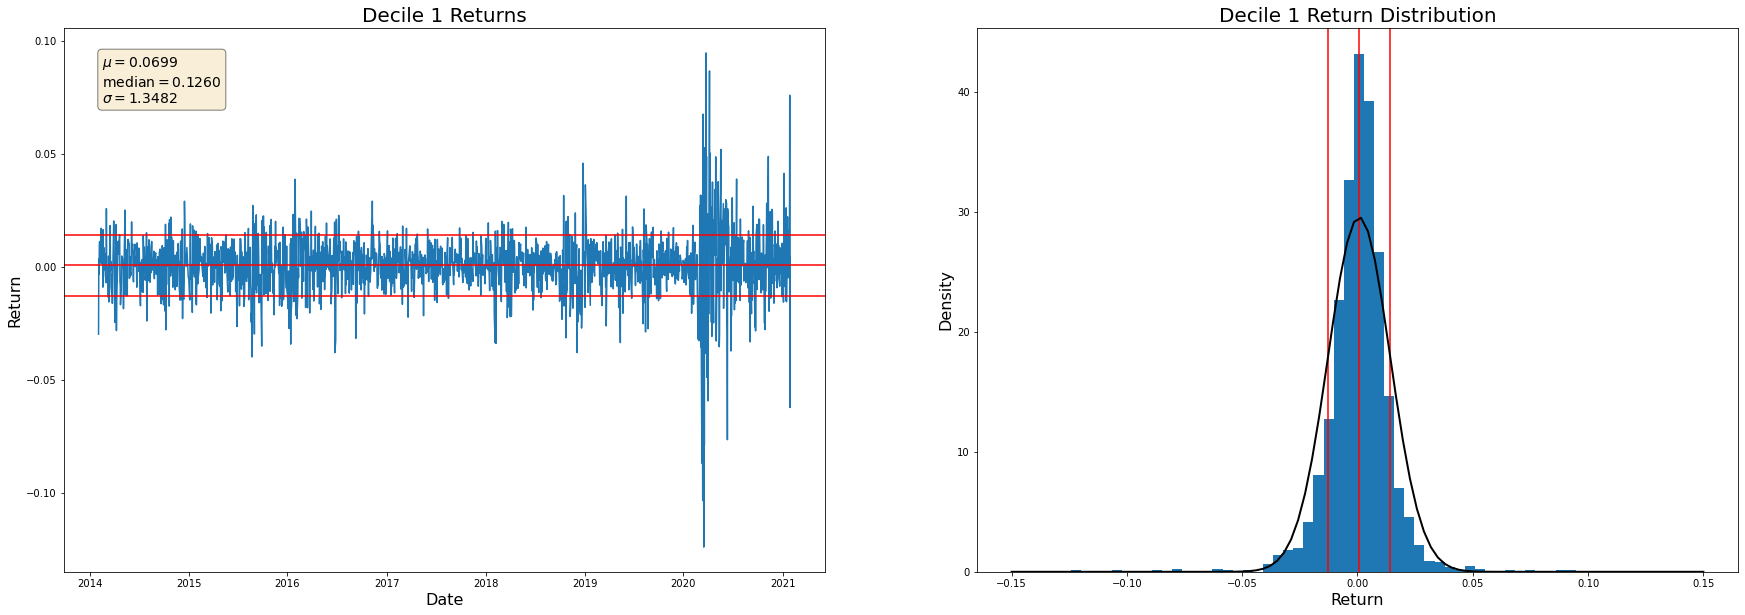

In [109]:
return_plots(debt_deciles['decile_1_ret'], 'Decile 1')

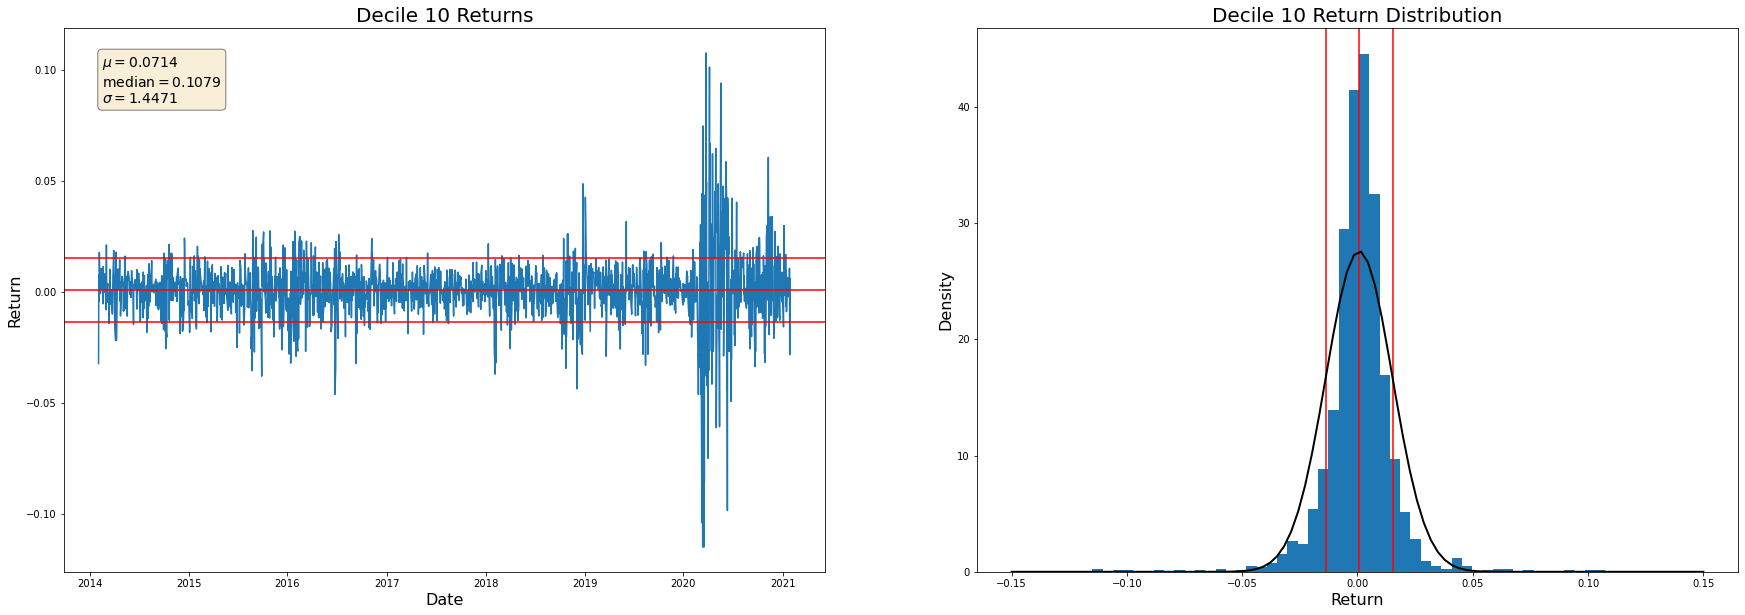

In [110]:
return_plots(debt_deciles['decile_10_ret'], 'Decile 10')

Text(0, 0.5, 'Cumulative Returns')

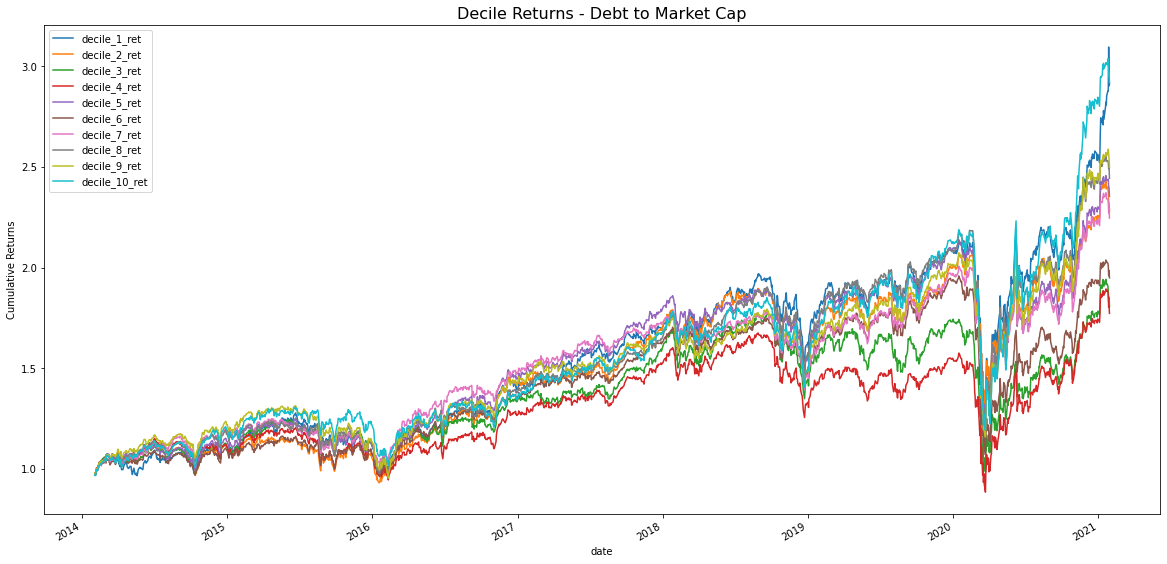

In [111]:
debt_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - Debt to Market Cap', size=16)
plt.ylabel('Cumulative Returns')

From this graph, we can see visually that the decile 10 performs the best (highest debt to market cap), whereas decile 3 & 4 (lower debt to market cap) performs the worst. In other words, the companies with highest leverage performs better than those that are not. Moreover, funding investments with debt rather than issuing equity results in higher returns for equity and prevents dilution of existing shares. This makes sense as companies that are highly leveraged are risky, which must reward investors with higher returns but also comes with higher volatility. Moreover, if a company has high debt, it could indicate that they will be able to better fund their investments and outperform their competitors

Therefore, we will construct a long-short portfolio longing decile 10 and shorting decile 1. 
* 0.5 - decile 10
* -0.5 - decile 1

After, we will vary the sizing by position rank by taking the following weights:
* 0.25 - decile 10, 0.15 - decile 9, 0.1 - decile 8
* -0.25 - decile 1, -0.15 - decile 2, -0.1 - decile 3

In [112]:
LS_weight = [-0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]
vary_weight = [-0.25, -0.15, -0.1, 0, 0, 0, 0, 0.1, 0.15, 0.25]

debt_LS_ret = create_portfolio(debt_deciles, LS_weight, 'debt_long_short') 
debt_LS_cum_ret = (1+debt_LS_ret).cumprod()

debt_vary_ret = create_portfolio(debt_deciles, vary_weight, 'debt_vary') 
debt_vary_cum_ret = (1+debt_vary_ret).cumprod()

all_strat.append(debt_LS_ret)
all_strat.append(debt_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


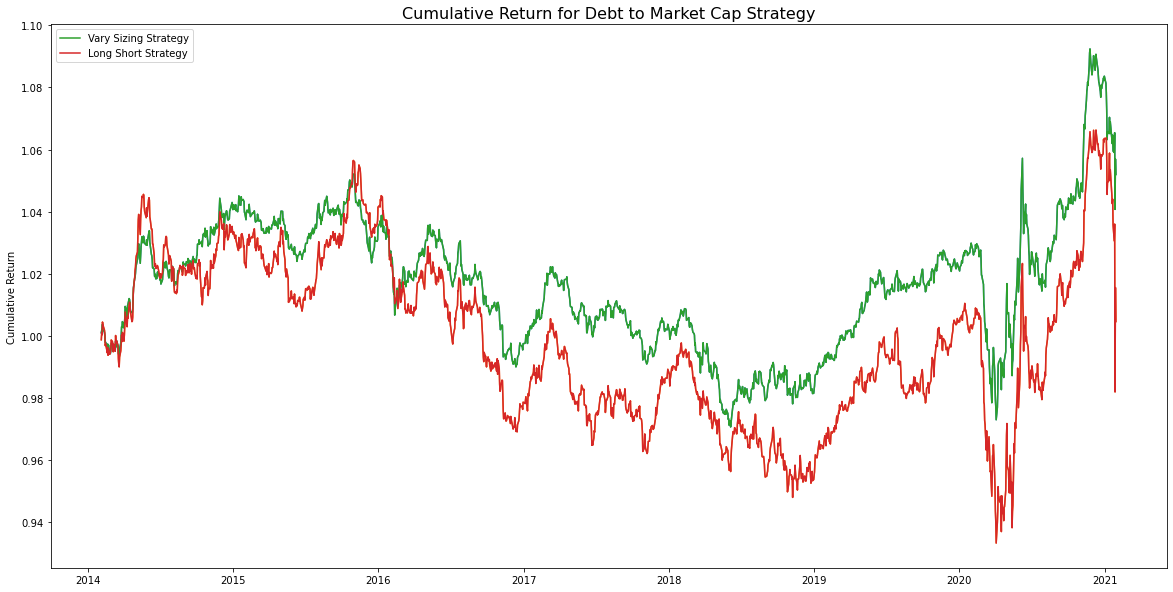

In [113]:
plt.subplots(figsize=(20,10))
plt.plot(debt_vary_cum_ret)
plt.plot(debt_LS_cum_ret)
plt.plot(debt_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(debt_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for Debt to Market Cap Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.legend()

From this graph, we see that the vary sizing strategy outperformed the long-short strategy. The diversification allowed for much better risk mitigation and the drawdown was much smaller in 2021. Moreover, the volatility associated with the vary sizing strategy was smaller than the long-short strategy. We see that the strategy performed strong until 2021, when the COVID pandemic happened, our strategy had a massive drawdown since we were long high risk companies that are highly leveraged. Therefore, both of our strategies experienced a significant negataive return over the last 2-3 months.

## Return on Investment

In [114]:
# Compute the returns of every decile
ROI_deciles = decile_performance(returns, ratios, 'ROI')
ROI_deciles_cum_ret = (1+ROI_deciles).cumprod()

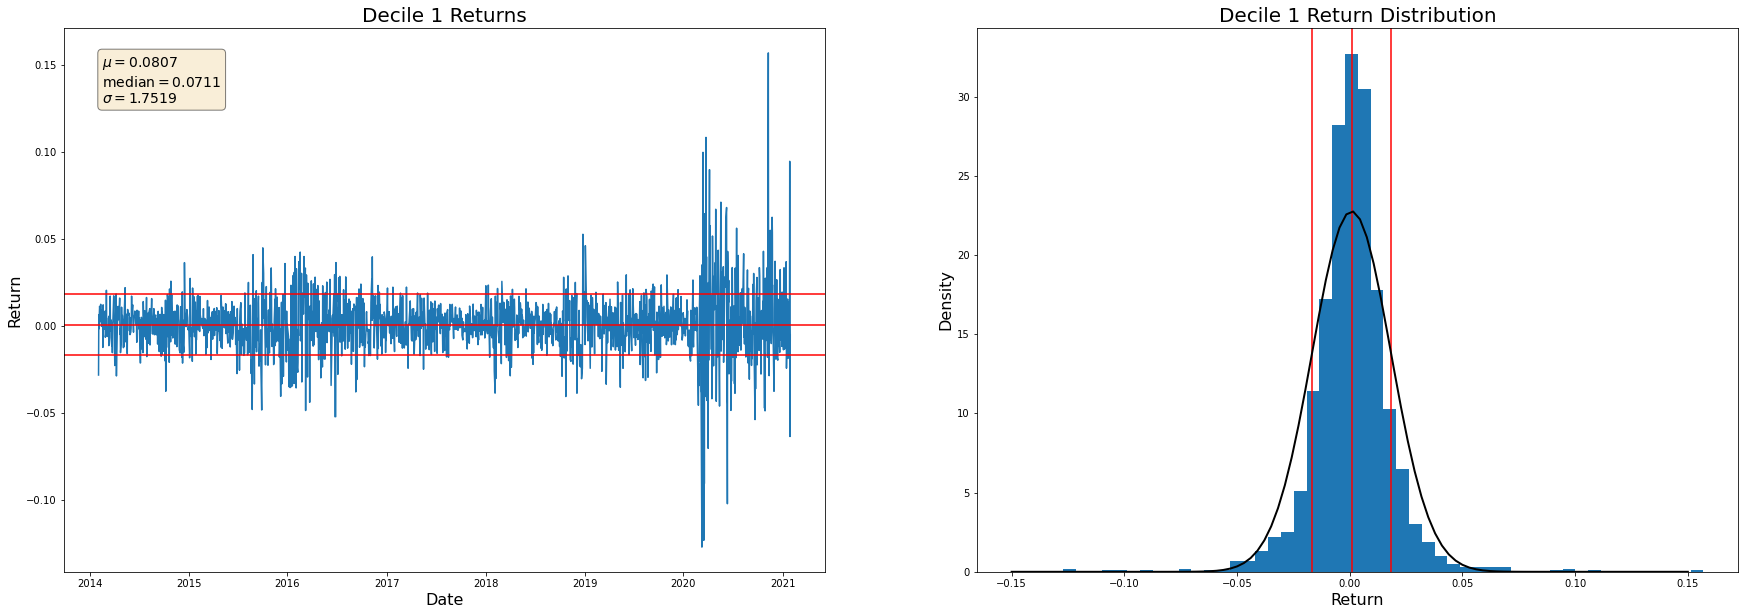

In [115]:
# Plot the 1st decile returns
return_plots(ROI_deciles['decile_1_ret'], 'Decile 1')

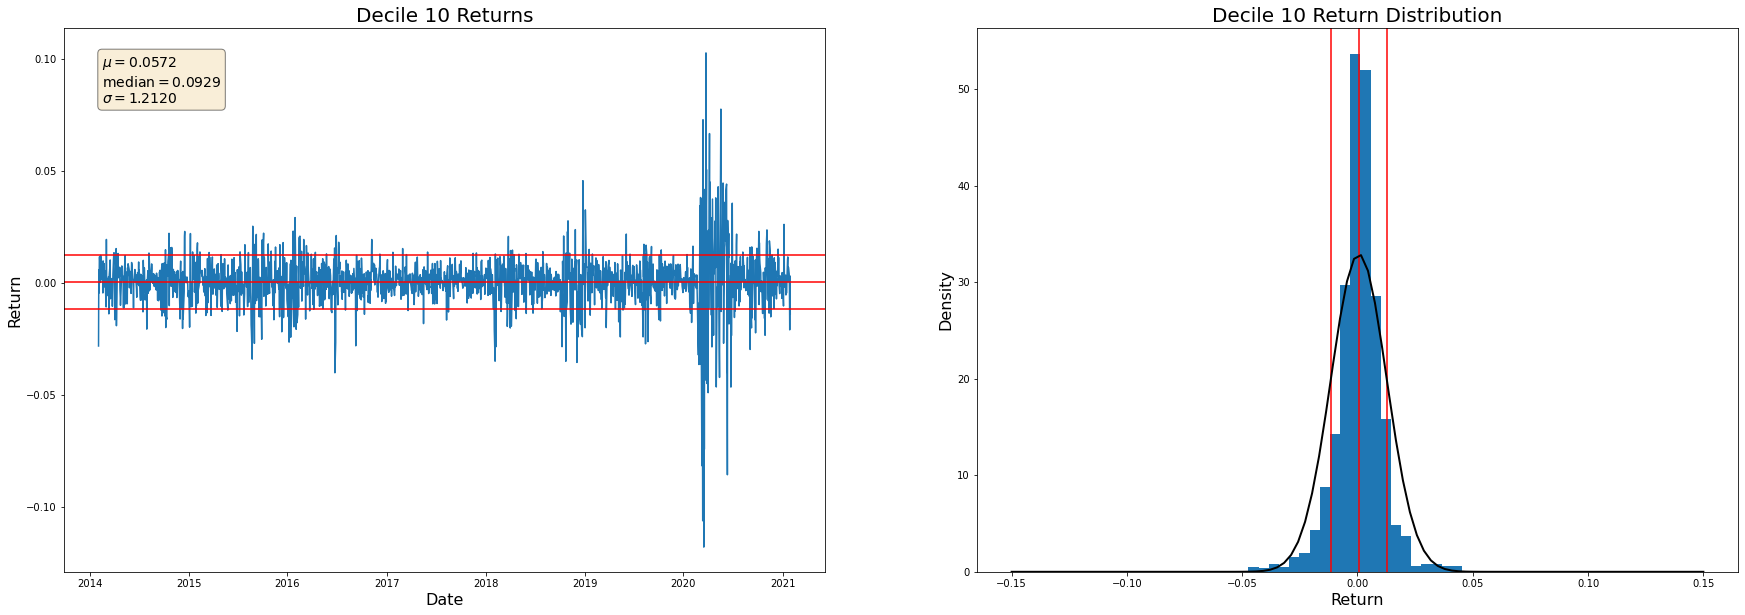

In [116]:
# Plot the 10th decile returns
return_plots(ROI_deciles['decile_10_ret'], 'Decile 10')

Text(0, 0.5, 'Cumulative Returns')

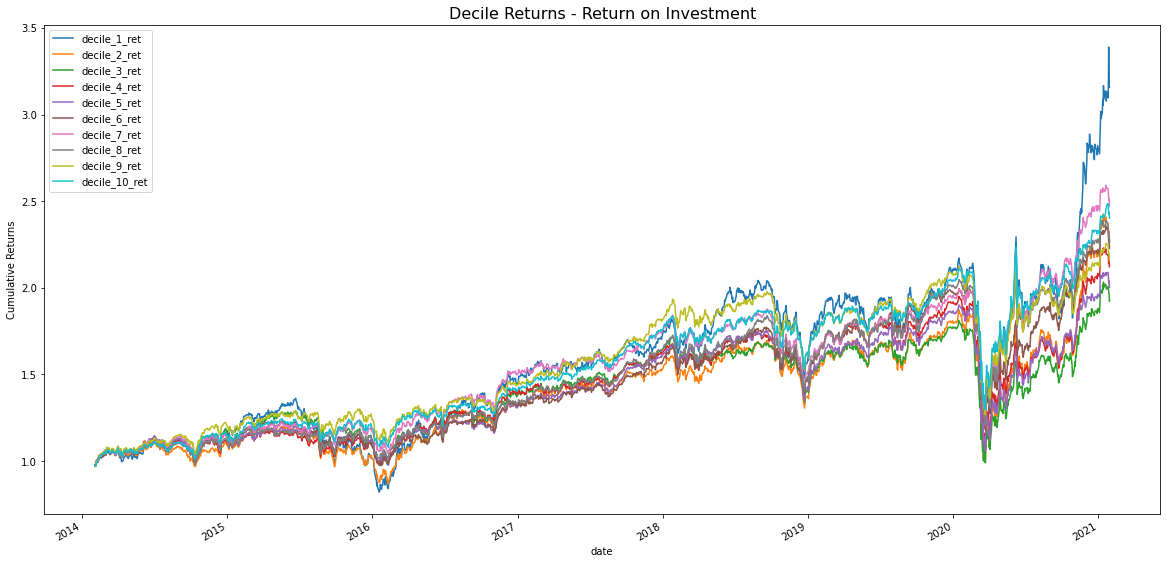

In [117]:
ROI_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - Return on Investment', size=16)
plt.ylabel('Cumulative Returns')

From the graph, it is difficult to assess which decile performs the best. As we can see, decile 1 underperformed the other deciles in the beginning of the period, however, they have one of the highest cumulative returns in the last few years. With the other deciles, it is difficult to distinguish if they have any difference. Therefore, it is possible that ROI is not a good predictor of future performance. However, we can conclude that companies with the lowest ROI outperformed the most so we will long that decile.

Therefore, we will construct a long-short portfolio shorting decile 10 and longing decile 1. 
* -0.5 - decile 10
* 0.5 - decile 1

After, we will vary the sizing by position rank by taking the following weights:
* -0.25 - decile 10, -0.15 - decile 9, -0.1 - decile 8
* 0.25 - decile 1, 0.15 - decile 2, 0.1 - decile 3

In [118]:
LS_weight = [0.5, 0, 0, 0, 0, 0, 0, 0, 0, -0.5]
vary_weight = [0.25, 0.15, 0.1, 0, 0, 0, 0, -0.1, -0.15, -0.25]

ROI_LS_ret = create_portfolio(ROI_deciles, LS_weight, 'ROI_long_short') 
ROI_LS_cum_ret = (1+ROI_LS_ret).cumprod()

ROI_vary_ret = create_portfolio(ROI_deciles, vary_weight, 'ROI_vary') 
ROI_vary_cum_ret = (1+ROI_vary_ret).cumprod()

all_strat.append(ROI_LS_ret)
all_strat.append(ROI_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


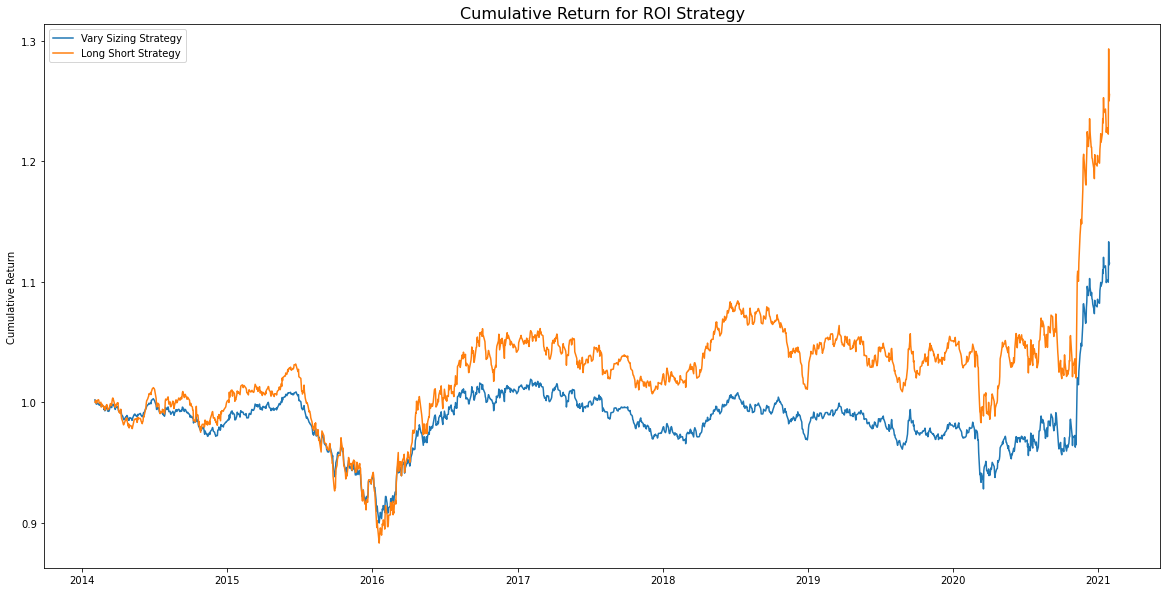

In [119]:
plt.subplots(figsize=(20,10))
plt.plot(ROI_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(ROI_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for ROI Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.legend()

From this graph, it appears that the vary sizing strategy underperformed the simple long short strategy. Moreover, the volatility with the vary sizing strategy is much lower, as expected due to the benefits of diversification.

## Price Earnings

In [120]:
# Compute returns for every decile
PE_deciles = decile_performance(returns, ratios, 'PE')
PE_deciles_cum_ret = (1+PE_deciles).cumprod()

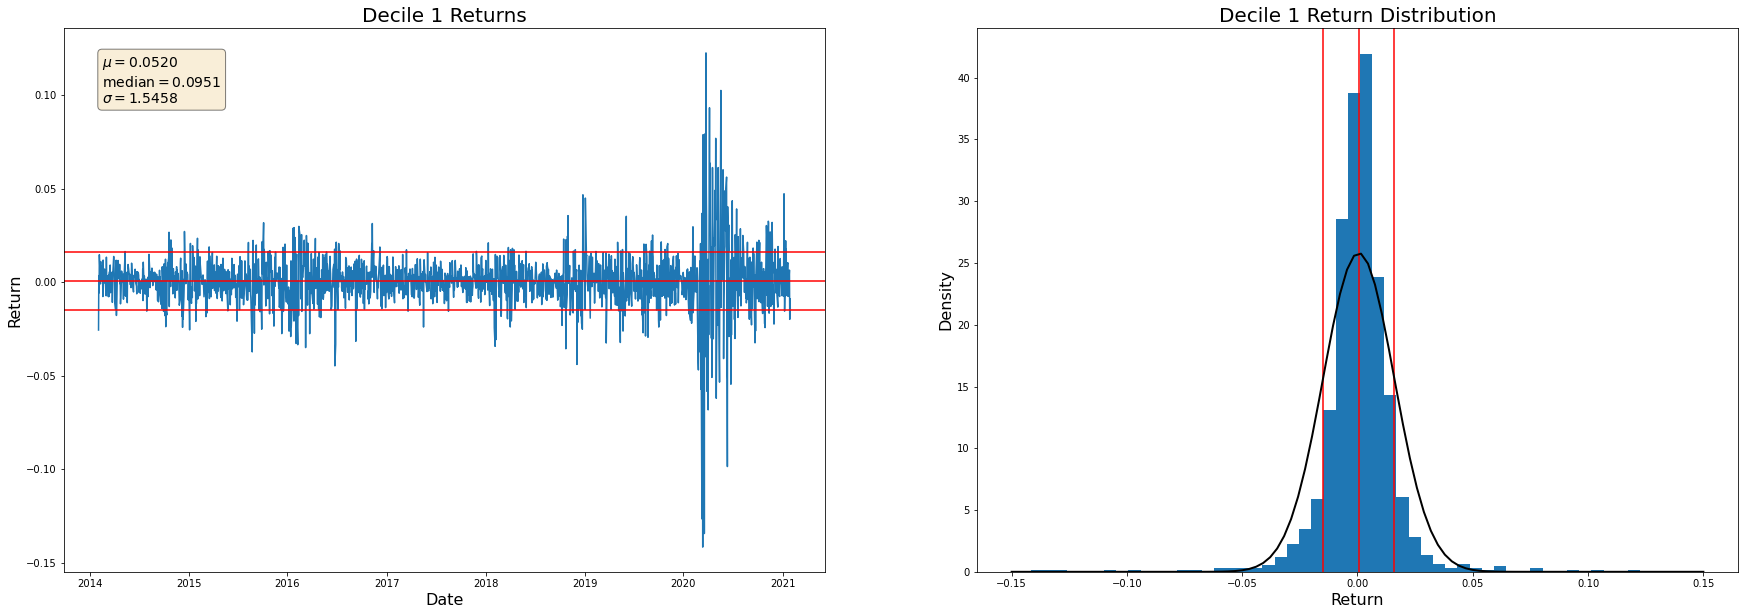

In [121]:
# Plot the 1st decile returns
return_plots(PE_deciles['decile_1_ret'], 'Decile 1')

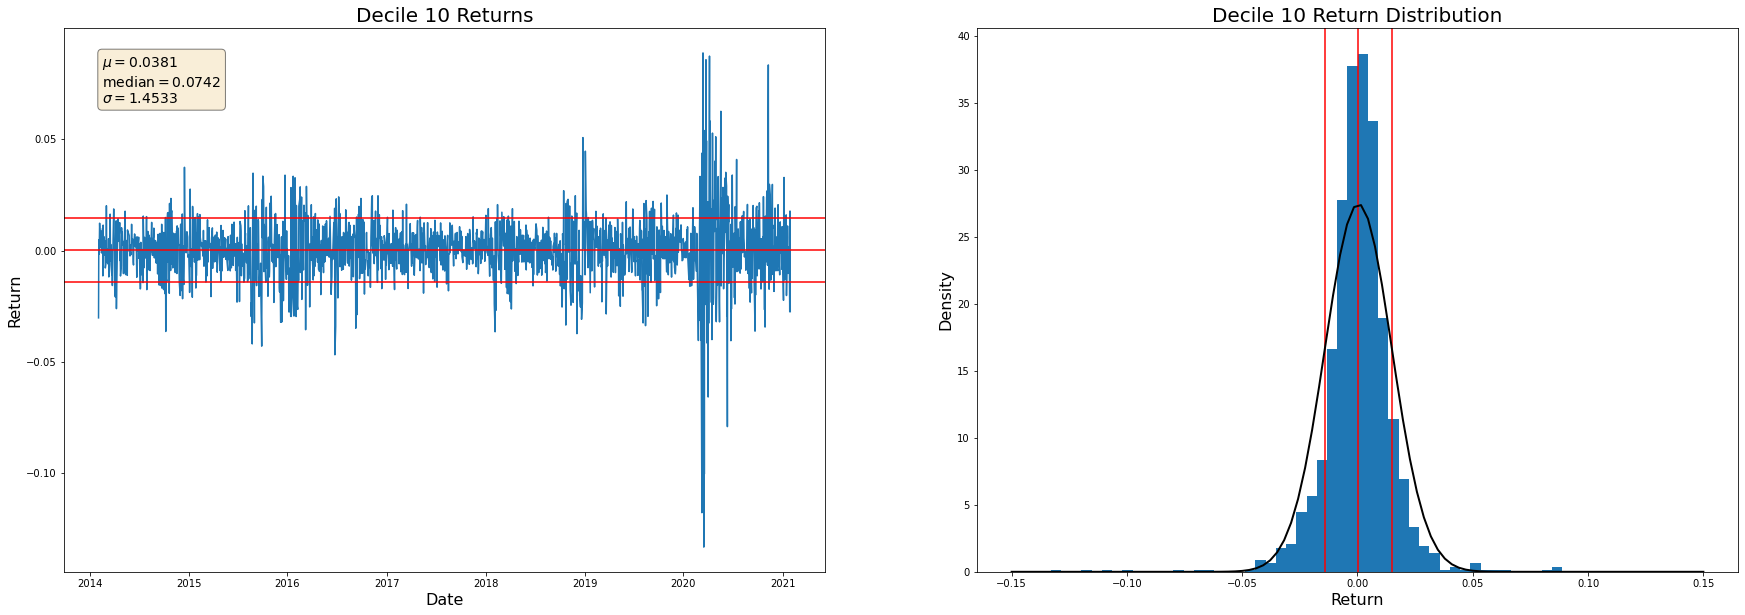

In [122]:
# Plot the 10th decile returns
return_plots(PE_deciles['decile_10_ret'], 'Decile 10')

Text(0, 0.5, 'Cumulative Returns')

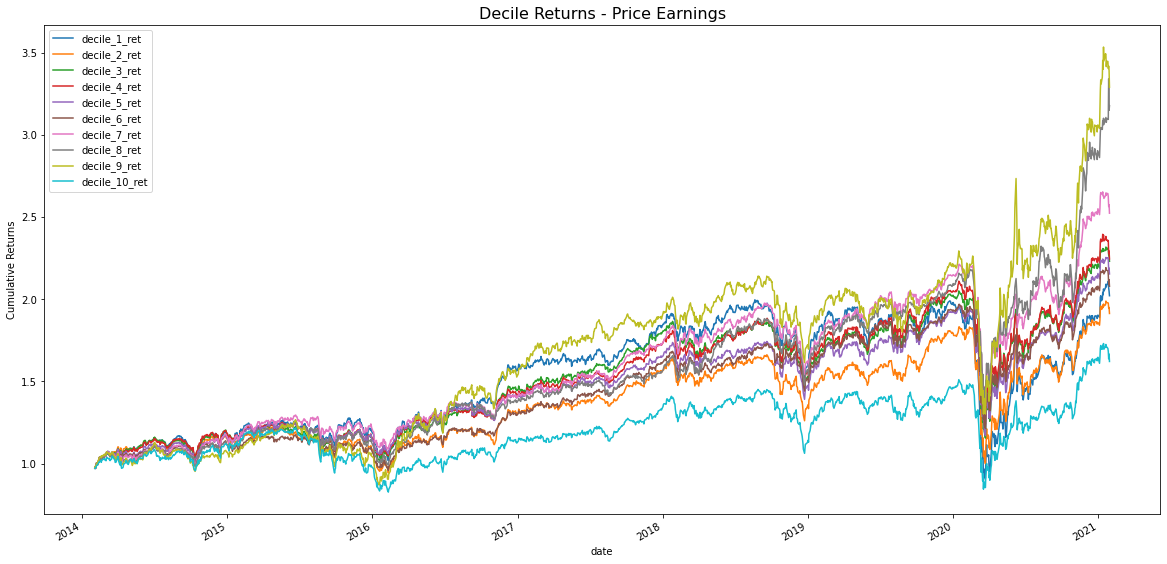

In [123]:
PE_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - Price Earnings', size=16)
plt.ylabel('Cumulative Returns')

From this graph, we can see visually that the decile 8 & 9 performs the best (second and third highest PE ratio), the group with the second highest PE ratio performs the best, where as decile 10 and 1 (highest PE ratio and lowest PE ratio) performs the worst. However, we should note that decile 10 contains all the company's with a negative EPS (since we made any negative EPS equal to 0.001). Therefore, we conclude that companies with low PE ratio perform much worse than companies with high PE ratio. Companies with high PE ratio tend to be technology and high growth stocks, that deliver superior returns but also have much higher volatility. 

Therefore, we will construct a long-short portfolio shorting decile 1 and longing decile 10. 
* -0.5 - decile 1
* 0.5 - decile 10

After, we will vary the sizing by position rank by taking the following weights:
* -0.25 - decile 1, -0.15 - decile 2, -0.1 - decile 3
* 0.25 - decile 10, 0.15 - decile 9, 0.1 - decile 8

In [124]:
LS_weight = [-0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]
vary_weight = [-0.25, -0.15, -0.1, 0, 0, 0, 0, 0.1, 0.15, 0.25]

PE_LS_ret = create_portfolio(PE_deciles, LS_weight, 'PE_long_short') 
PE_LS_cum_ret = (1+PE_LS_ret).cumprod()

PE_vary_ret = create_portfolio(PE_deciles, vary_weight, 'PE_vary') 
PE_vary_cum_ret = (1+PE_vary_ret).cumprod()

all_strat.append(PE_LS_ret)
all_strat.append(PE_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


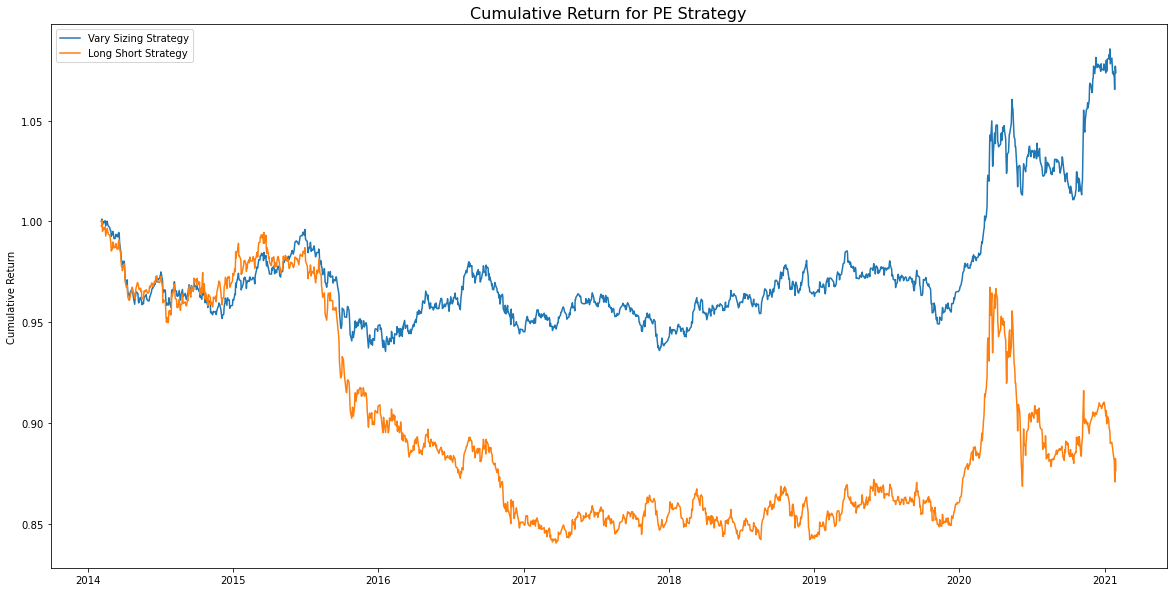

In [125]:
plt.subplots(figsize=(20,10))
plt.plot(PE_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(PE_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for PE Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.legend()

In this graph, we see that the vary sizing strategy actually outperformed the long short strategy. Despite having more diversification, longing and shorting the top/bottom 3 quantiles performed better than just the long-short strategy. As we have seen by analyzing the deciles, we see that deciles 8 and 9 performed the best while deciles 1 performed the worst. Hence, by adding these deciles to our portfolio, we can generate much stronger returns.

## Combination - Debt/Market Cap - Price to Earnings

As we have seen in the previous analysis, the 2 ratios with a significant variation across deciles is the Debt/Market Cap ratio and the price to earnings ratio. In the debt/market cap ratio, we see that a stocks with higher debt/market has a higher return, which is most likely to compensate investors with a higher return for investing in a high leverage company. On the other hand, we see that companies with a high PE ratio outperformed those with a lowerer PE ratio. In other words, growth companies performance outperformed value companies, as expected. We will combine these 2 ratios by having Debt/Market Cap Ratio + (-Price to Earnings Ratio).

In [126]:
# Calculate z scores for debt to market and PE ratio
ratios['debt_to_mkt_z_score'] = (ratios['debt_to_mkt_cap'] - ratios['debt_to_mkt_cap'].mean())/ \
                                    ratios['debt_to_mkt_cap'].std()

ratios['PE_z_score'] = (ratios['PE'] - ratios['PE'].mean()) / ratios['PE'].std()

# Combine the z score of debt to market and PE ratio with formula: debt to mkt - PE
ratios['combination'] = ratios['debt_to_mkt_z_score'] - ratios['PE_z_score']

In [127]:
# Compute all decile returns
comb_deciles = decile_performance(returns, ratios, 'combination')
comb_deciles_cum_ret = (1+comb_deciles).cumprod()

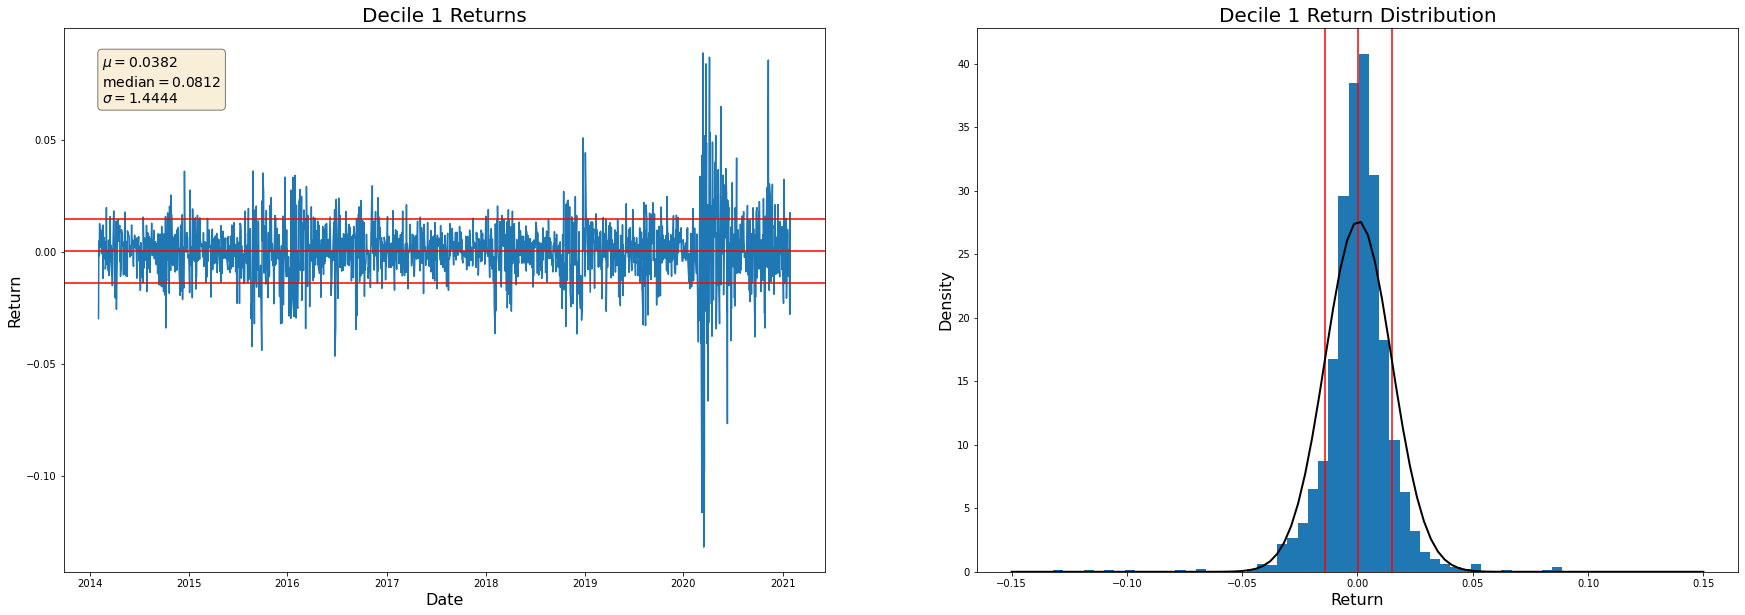

In [128]:
# Plot the 1st decile returns
return_plots(comb_deciles['decile_1_ret'], 'Decile 1')

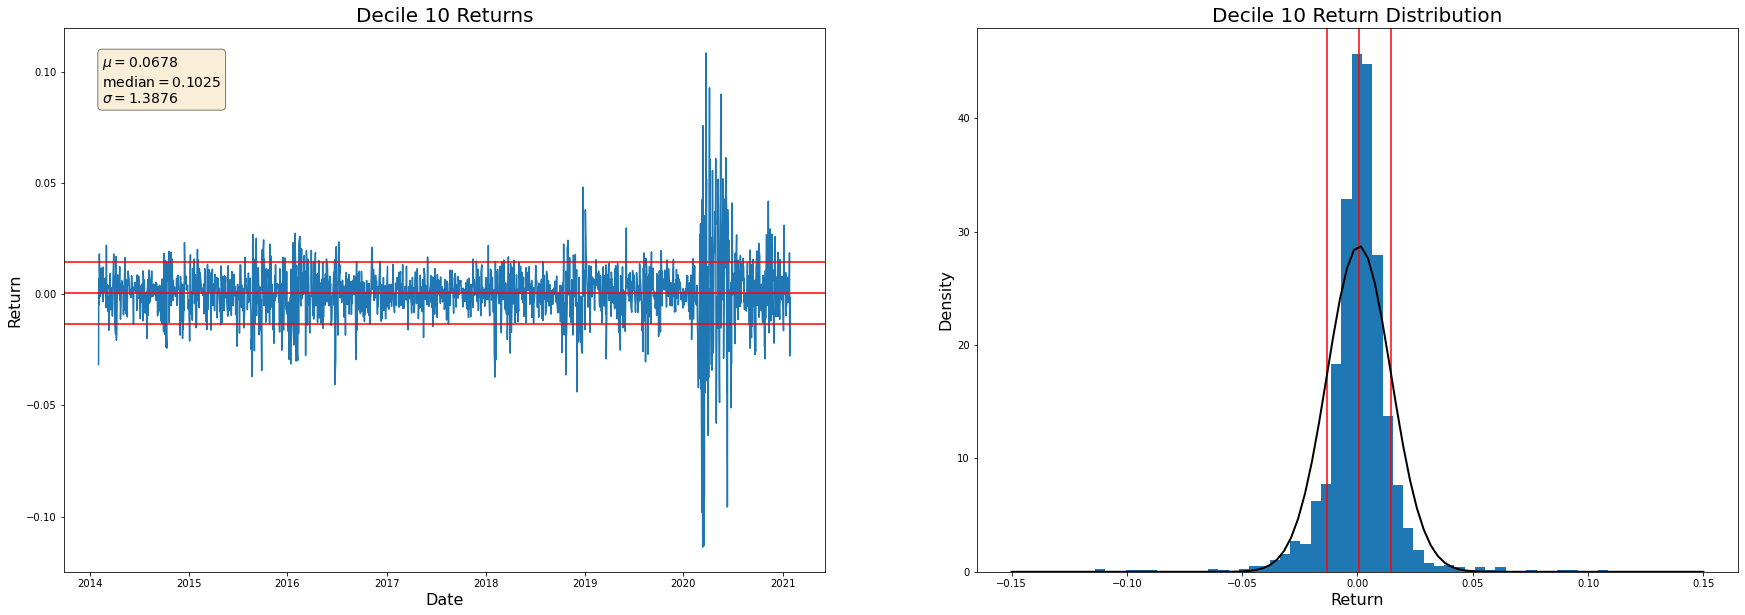

In [129]:
# Plot the 10th decile returns
return_plots(comb_deciles['decile_10_ret'], 'Decile 10')

Text(0, 0.5, 'Cumulative Returns')

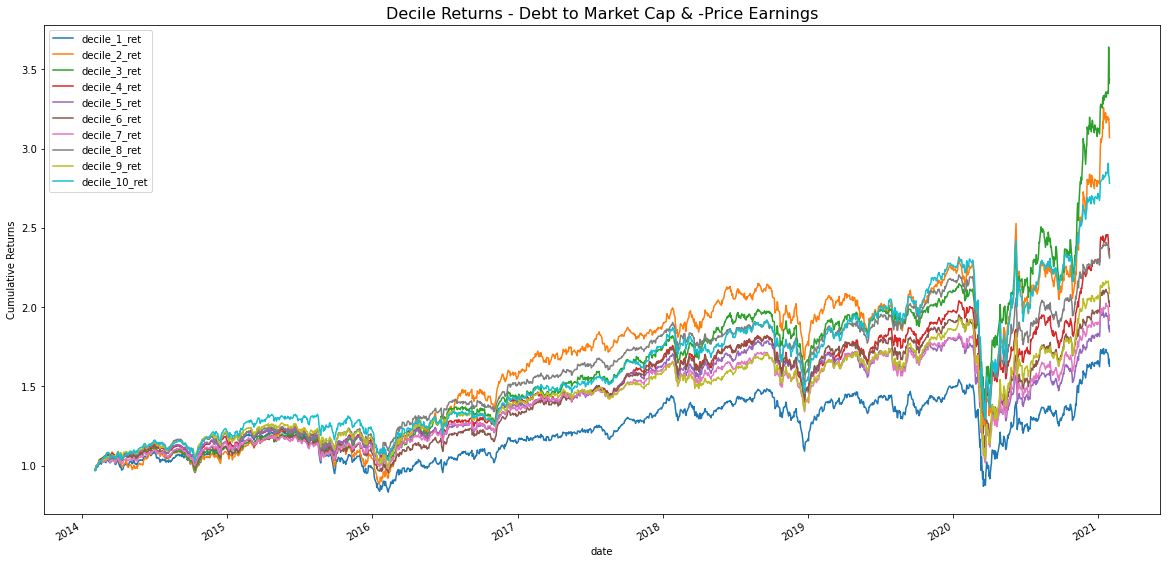

In [130]:
comb_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - Debt to Market Cap & -Price Earnings', size=16)
plt.ylabel('Cumulative Returns')

From this graph, we can see visually that the decile 2, 3 and 10 performs the best, whereas decile 1,4 and 7 performs the worst. This agrees from our results from the debt to market cap ratio and the PE ratio, so a combination of the 2 ratios yielded the decile results that we expected.

Therefore, we will construct a long-short portfolio longing decile 10 and shorting decile 1. 
* 0.5 - decile 10
* -0.5 - decile 1

After, we will vary the sizing by position rank by taking the following weights:
* 0.25 - decile 10, 0.15 - decile 9, 0.1 - decile 8
* -0.25 - decile 1, -0.15 - decile 2, -0.1 - decile 3

In [131]:
LS_weight = [-0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]
vary_weight = [-0.25, -0.15, -0.1, 0, 0, 0, 0, 0.1, 0.15, 0.25]

comb_LS_ret = create_portfolio(comb_deciles, LS_weight, 'comb_long_short') 
comb_LS_cum_ret = (1+comb_LS_ret).cumprod()

comb_vary_ret = create_portfolio(comb_deciles, vary_weight, 'comb_vary') 
comb_vary_cum_ret = (1+comb_vary_ret).cumprod()

all_strat.append(comb_LS_ret)
all_strat.append(comb_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


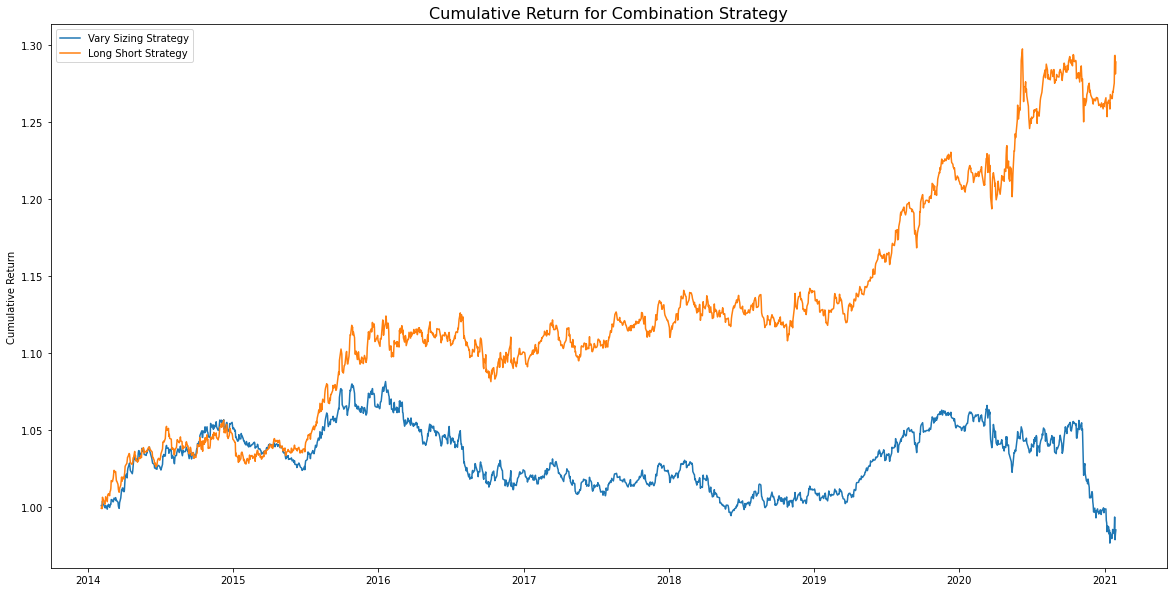

In [132]:
plt.subplots(figsize=(20,10))
plt.plot(comb_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(comb_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for Combination Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.plot()
plt.legend()

Similarly, the long short strategy experienced higher volatility, but also yielded a better return than the vary sizing strategy. The long short strategy was able to generate a solid return of almost 30% by the end of 2021. Adding in the additional quantiles hindered our returns, despite lowering volatility.

## Change in Ratios

Now, we will explore how the quantile strategy performs when we rank in my ratios rather than the ratios themselves. Again, we will also vary the effects of sizing by rank.

#### Change in Debt to Market Cap Ratio

In [133]:
# Compute all decile returns
debt_chg_deciles = decile_performance(returns, ratios, 'debt_to_mkt_cap_diff')
debt_chg_deciles_cum_ret = (1+debt_chg_deciles).cumprod()

Text(0, 0.5, 'Cumulative Returns')

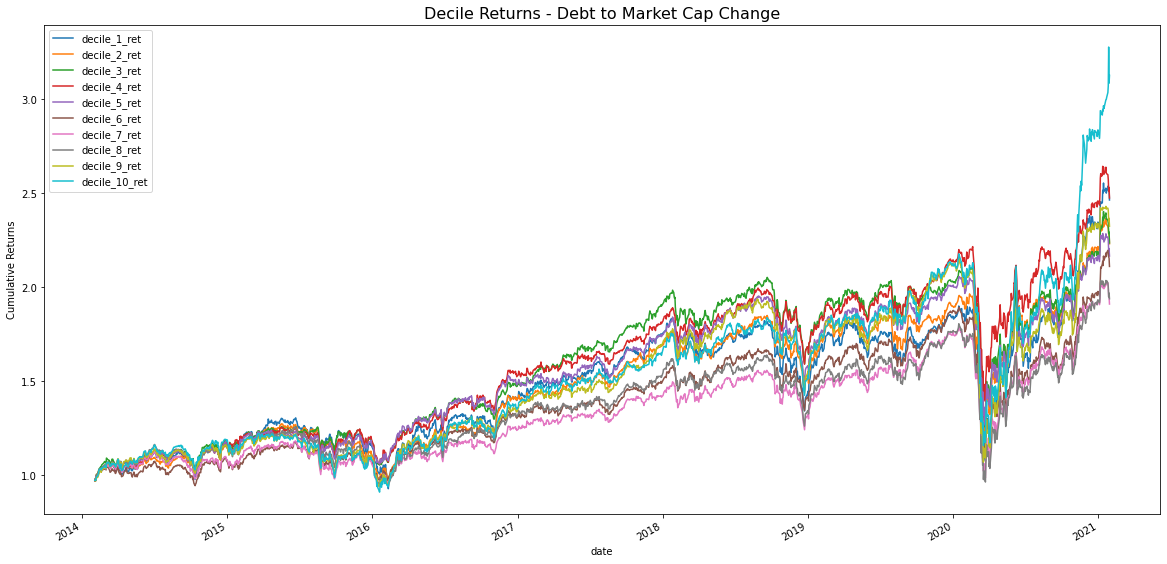

In [134]:
debt_chg_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - Debt to Market Cap Change', size=16)
plt.ylabel('Cumulative Returns')

From the cumulative plots of the deciles, it is difficult to conclude if there is a signal within each decile. However, we see that the best performing is decile 10, which means that a large increase in debt to market cap ratio has a higher return. Again, this could be that a increase in debt means that the company is more likely to experience more growth into the future, which increases the stock price. Moreover, being more leveraged increases the volatility with the company, which also rewards investors with higher returns.

Therefore, we will construct a long-short portfolio longing decile 10 and shorting decile 1. 
* 0.5 - decile 10
* -0.5 - decile 1

After, we will vary the sizing by position rank by taking the following weights:
* 0.25 - decile 10, 0.15 - decile 9, 0.1 - decile 8
* -0.25 - decile 1, -0.15 - decile 2, -0.1 - decile 3

In [135]:
LS_weight = [-0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]
vary_weight = [-0.25, -0.15, -0.1, 0, 0, 0, 0, 0.1, 0.15, 0.25]

debt_chg_LS_ret = create_portfolio(debt_chg_deciles, LS_weight, 'debt_chg_long_short') 
debt_chg_LS_cum_ret = (1+debt_chg_LS_ret).cumprod()

debt_chg_vary_ret = create_portfolio(debt_chg_deciles, vary_weight, 'debt_chg_vary') 
debt_chg_vary_cum_ret = (1+debt_chg_vary_ret).cumprod()

all_strat.append(debt_chg_LS_ret)
all_strat.append(debt_chg_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


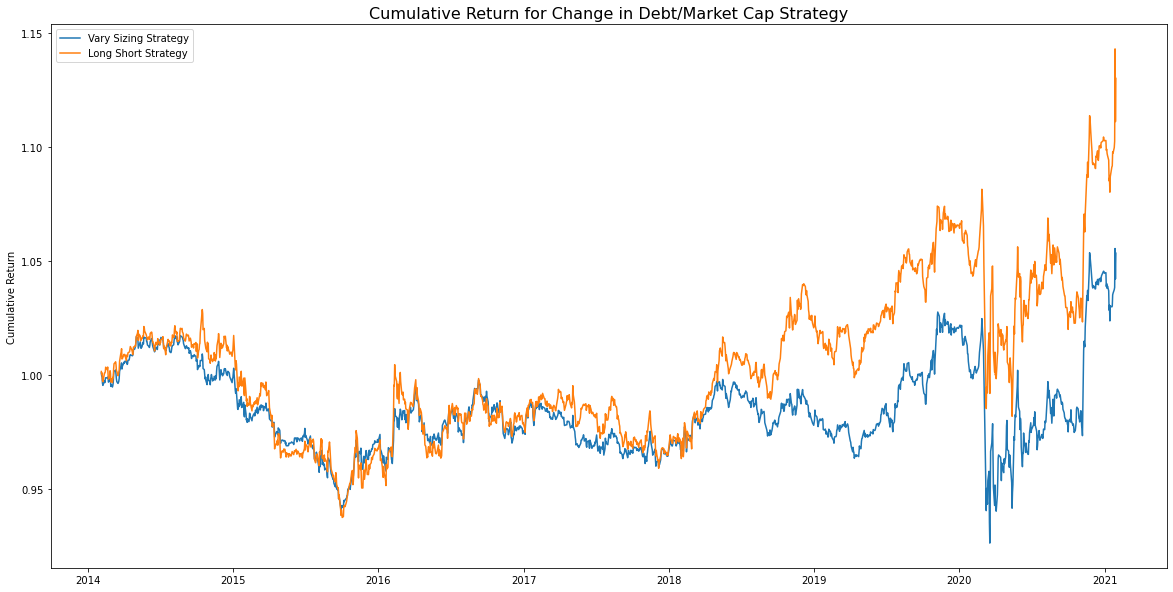

In [136]:
plt.subplots(figsize=(20,10))
plt.plot(debt_chg_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(debt_chg_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for Change in Debt/Market Cap Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.plot()
plt.legend()

#### Change in ROI Ratio

In [137]:
ROI_chg_deciles = decile_performance(returns, ratios, 'ROI_diff')
ROI_chg_deciles_cum_ret = (1+ROI_chg_deciles).cumprod()

Text(0, 0.5, 'Cumulative Returns')

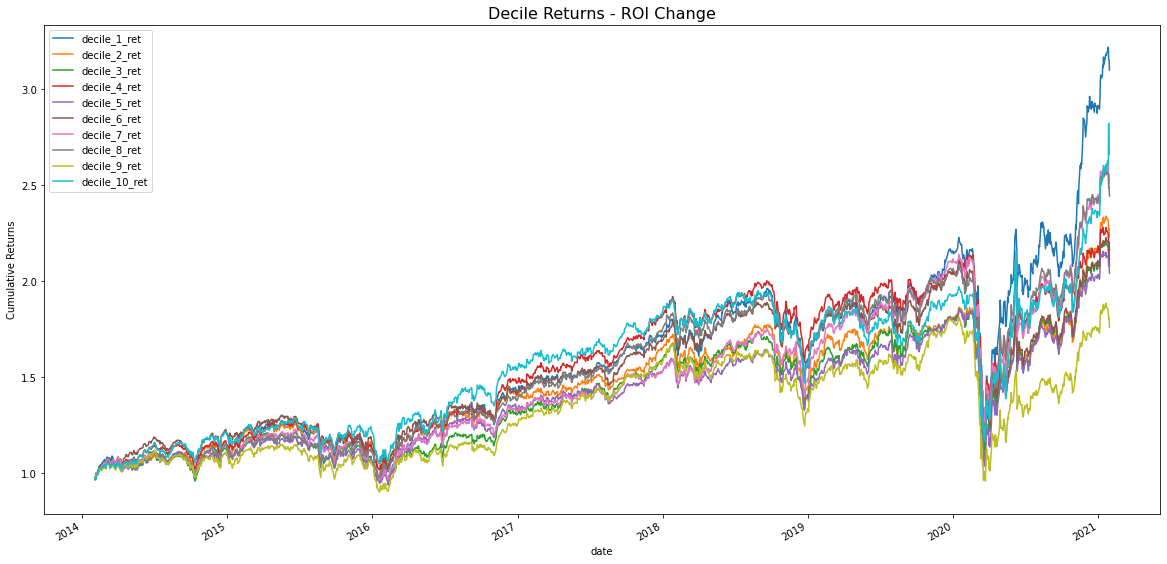

In [138]:
ROI_chg_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - ROI Change', size=16)
plt.ylabel('Cumulative Returns')

From the cumulative plots of the deciles, we can clearly see that decile 1 performed the best, while decile 9 performed the worst. This indicates that the decile where ROI has decreased the most had a higher return compared to company's where the ROI has increased. When a company's ROI decreases, it means that their market value has increased, by either having the company issue more shares or through stock appreciation. Therefore, a decrease in ROI means that the company's stock price increased, which could be why decile 1 has the highest return. Another possibility is that when a company decreases their ROI ratio, it means that they are now generating lower net income for their overall investments. These companies are generally much riskier, and investing in them can result in a higher return.

Therefore, we will construct a long-short portfolio longing decile 1 and shorting decile 10. 
* 0.5 - decile 1
* -0.5 - decile 10

After, we will vary the sizing by position rank by taking the following weights:
* 0.25 - decile 1, 0.15 - decile 2, 0.1 - decile 3
* -0.25 - decile 10, -0.15 - decile 9, -0.1 - decile 8


In [139]:
LS_weight = [0.5, 0, 0, 0, 0, 0, 0, 0, 0, -0.5]
vary_weight = [0.25, 0.15, 0.1, 0, 0, 0, 0, -0.1, -0.15, -0.25]

ROI_chg_LS_ret = create_portfolio(ROI_chg_deciles, LS_weight, 'ROI_chg_long_short') 
ROI_chg_LS_cum_ret = (1+ROI_chg_LS_ret).cumprod()

ROI_chg_vary_ret = create_portfolio(ROI_chg_deciles, vary_weight, 'ROI_chg_vary') 
ROI_chg_vary_cum_ret = (1+ROI_chg_vary_ret).cumprod()

all_strat.append(ROI_chg_LS_ret)
all_strat.append(ROI_chg_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


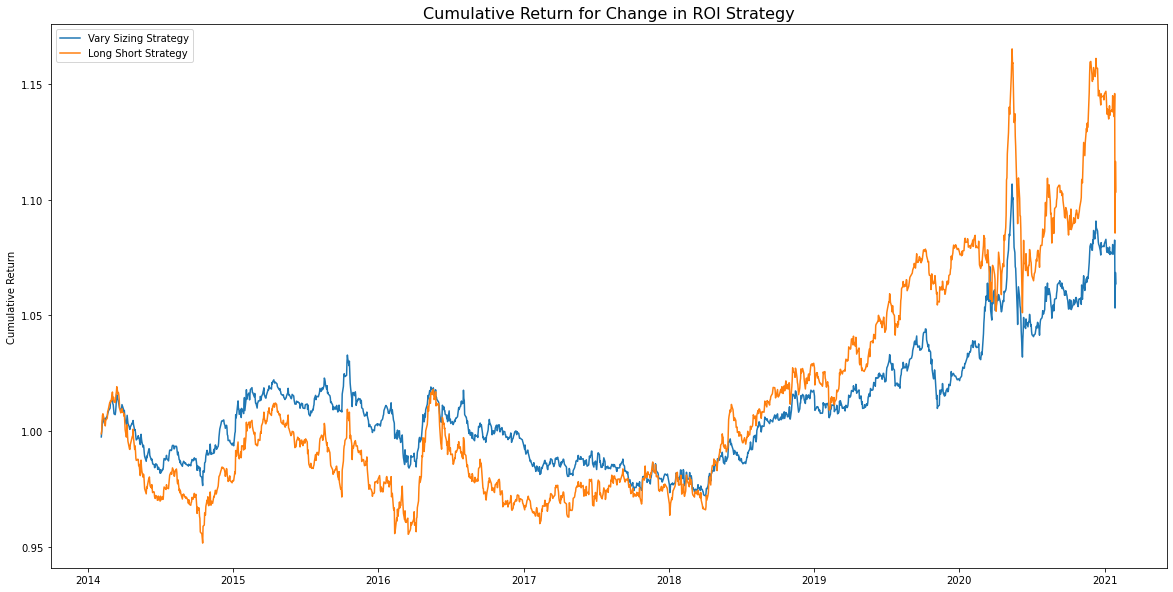

In [140]:
plt.subplots(figsize=(20,10))
plt.plot(ROI_chg_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(ROI_chg_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for Change in ROI Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.plot()
plt.legend()

#### Change in PE Ratio

In [141]:
# Compute returns for all deciles
PE_chg_deciles = decile_performance(returns, ratios, 'PE_diff')
PE_chg_deciles_cum_ret = (1+PE_chg_deciles).cumprod()

Text(0, 0.5, 'Cumulative Returns')

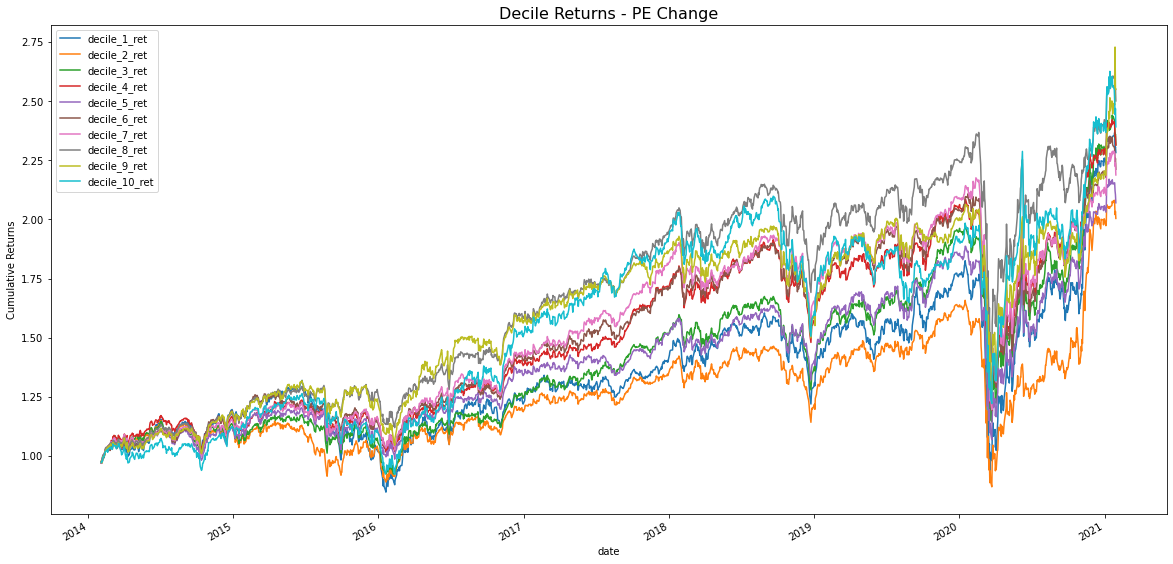

In [142]:
PE_chg_deciles_cum_ret.plot(figsize=(20,10))
plt.title('Decile Returns - PE Change', size=16)
plt.ylabel('Cumulative Returns')

From the cumulative plots of the deciles, it is difficult to conclude whether there is any significant variation across the deciles. However, from our previous analysis, we know that companies with higher PE ratio outperfroms companies with low PE ratios. Therefore, we would expect a positive increase in PE ratios to outperform a decrease in PE ratios. An increase in this ratio could indicate higher prices, potentially generating superior returns into the future.


Therefore, we will construct a long-short portfolio shorting decile 1 and longing decile 10. 
* -0.5 - decile 1
* 0.5 - decile 10

After, we will vary the sizing by position rank by taking the following weights:
* -0.25 - decile 1, -0.15 - decile 2, -0.1 - decile 3
* 0.25 - decile 10, 0.15 - decile 9, 0.1 - decile 8

In [143]:
LS_weight = [-0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0.5]
vary_weight = [-0.25, -0.15, -0.1, 0, 0, 0, 0, 0.1, 0.15, 0.25]

PE_chg_LS_ret = create_portfolio(PE_chg_deciles, LS_weight, 'PE_chg_long_short') 
PE_chg_LS_cum_ret = (1+PE_chg_LS_ret).cumprod()

PE_chg_vary_ret = create_portfolio(PE_chg_deciles, vary_weight, 'PE_chg_vary') 
PE_chg_vary_cum_ret = (1+PE_chg_vary_ret).cumprod()

all_strat.append(PE_chg_LS_ret)
all_strat.append(PE_chg_vary_ret)
print('Calculated long short and vary sizing strategy returns')

Calculated long short and vary sizing strategy returns


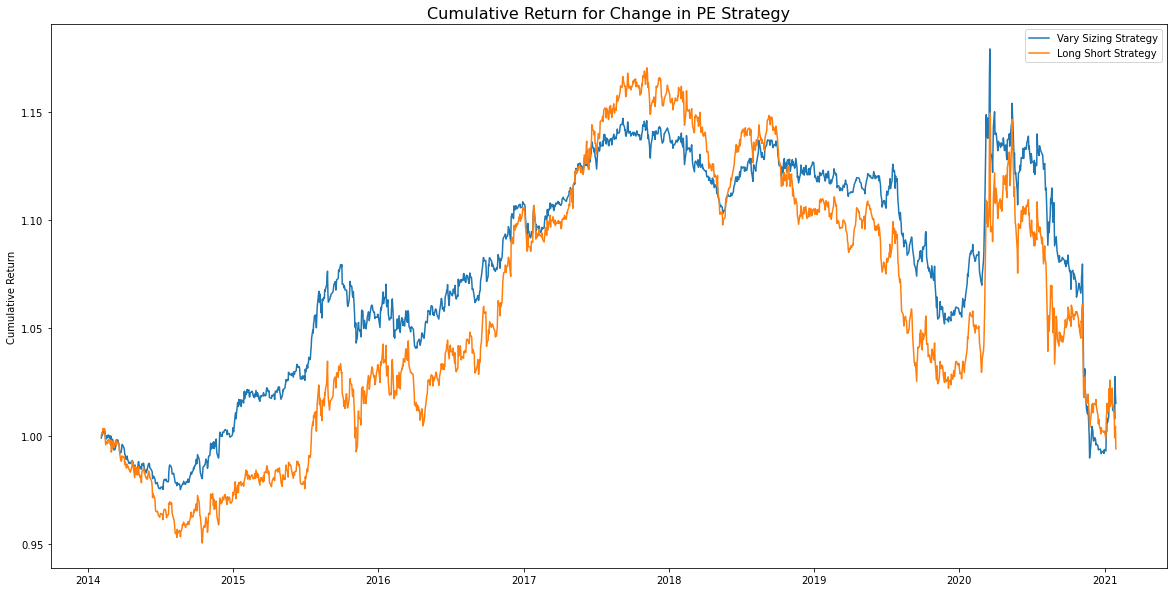

In [144]:
plt.subplots(figsize=(20,10))
plt.plot(PE_chg_vary_cum_ret, label='Vary Sizing Strategy')
plt.plot(PE_chg_LS_cum_ret, label='Long Short Strategy')
plt.title('Cumulative Return for Change in PE Strategy', size=16)
plt.ylabel('Cumulative Return')
plt.plot()
plt.legend()

## Analysis of all strategies

###### Import functions for analyzing strategy returns

In [145]:
# Performance_metrics
def return_stats(returns, annualization=1):
    stats = pd.DataFrame(index=returns.columns)
    stats['mean'] = returns.mean() * annualization
    stats['vol'] = returns.std() * np.sqrt(annualization)
    stats['Sharpe'] = stats['mean'] / stats['vol']

    stats['min'] = returns.min()
    stats['max'] = returns.max()

    return stats

# Tail risk stats
def max_drawdown(returns):
    
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    
    # date of bottom
    min_date = drawdown.idxmin()
    min_level = cum_returns.loc[min_date]
    
    # date of previous max
    max_date = cum_returns.loc[cum_returns.index <= min_date].idxmax()
    max_level = cum_returns.loc[max_date]
    
    try:
        recovery_date = cum_returns.loc[cum_returns.index > min_date][cum_returns >= max_level].index[0] # first time it is greater
    except:
        recovery_date = None
    
    return (min_level - max_level)/max_level, max_date, min_date, recovery_date

def tail_risk_stats(returns):
    stats = pd.DataFrame(index=returns.columns)
    stats['Skewness'] = returns.skew()
    stats['Excess Kurtosis'] = returns.kurtosis() - 3
    stats['VaR 0.05'] = returns.quantile(0.05)
    stats['CVaR 0.05'] = returns[returns <= returns.quantile(0.05)].mean()
    
    for fund in stats.index:
        stats.loc[fund, ['Max Drawdown', 'Peak', 'Bottom', 'Recover']] = max_drawdown(returns[fund])
        
    return stats

# Correlations of Returns
def display_corr(df, print_maxmin=True):
    
    corr = df.corr()
    corr[corr==1] = None
    plt.figure(figsize = (15,8))
    sns.heatmap(corr, annot=True)

    if print_maxmin:
        corr_rank = corr.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')
        
    return corr

In [146]:
all_strat = pd.concat(all_strat, axis=1)
all_strat_cum_ret = (1+all_strat).cumprod()

##### Cumulative Return Plot

Text(0, 0.5, 'Cumulative Return')

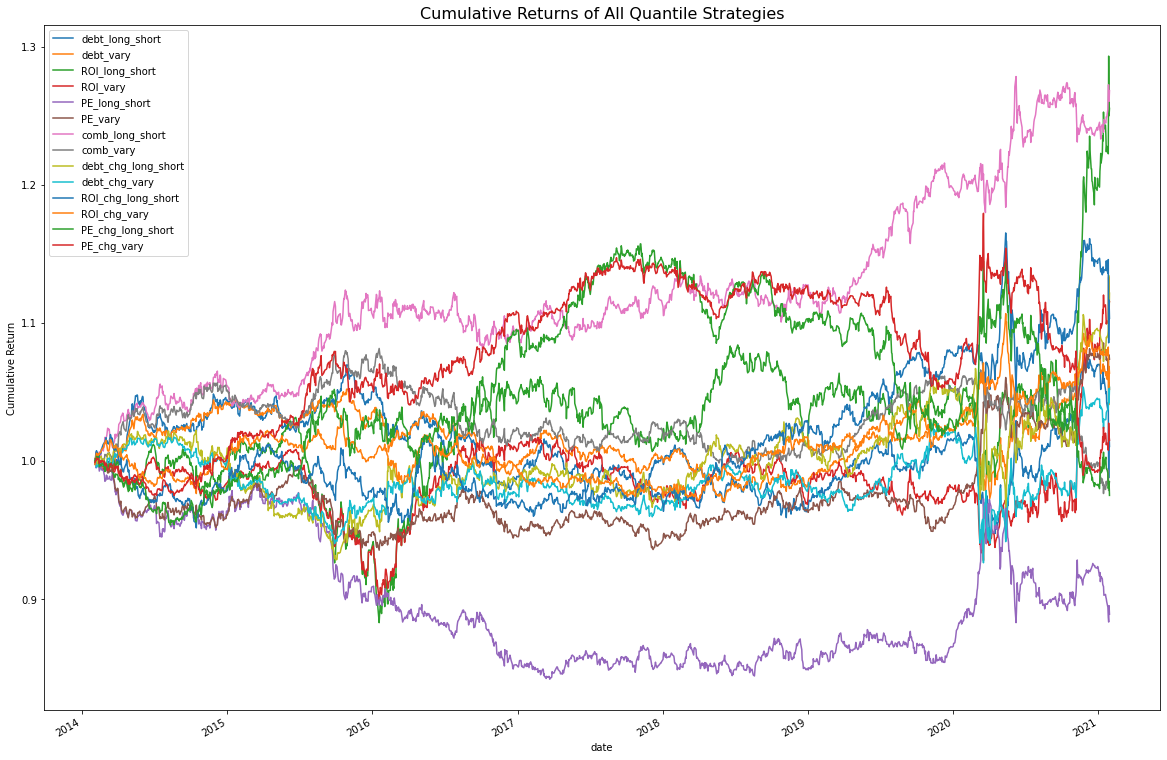

In [147]:
all_strat_cum_ret.plot(figsize=(20, 14))
plt.title('Cumulative Returns of All Quantile Strategies', size=16)
plt.ylabel('Cumulative Return')

Combining all the strategies, we see that the strongest signal is using a combination of the debt/market and PE ratio and ROI long-short. This yielded the greatest return of our trading duration with a cumulative return of over 30% by longing the 10th decile and shorting the 1st decile. Since we have combined multiple strong signals, we were able to deliver a much better return with the long short strategy. On the other hand, we see that P/E provided the worst signal. Although the strategy did not experience a substantial loss, it had done the wosrt by dropping about 10% throughout our trading time frame. For the other strategies, they had cumulative returns within the debt/market cap and ROI returns. From the best performing to the worst performing strategy, there is about a 40% difference in cumulative returns.

##### Return Statistics

In [148]:
ret_stats = return_stats(all_strat, annualization=252)
ret_stats

mean       vol    Sharpe       min       max
debt_long_short      0.002765  0.049088  0.056320 -0.052158  0.034218
debt_vary            0.008026  0.034670  0.231494 -0.023161  0.015576
ROI_long_short       0.036614  0.081536  0.449048 -0.033373  0.082429
ROI_vary             0.017478  0.054701  0.319511 -0.019131  0.057627
PE_long_short       -0.015901  0.051144 -0.310912 -0.019941  0.025427
PE_vary              0.011207  0.039225  0.285702 -0.013290  0.034425
comb_long_short      0.035803  0.044438  0.805697 -0.021864  0.013994
comb_vary           -0.001508  0.037233 -0.040494 -0.028717  0.008535
debt_chg_long_short  0.018628  0.060280  0.309020 -0.031702  0.038565
debt_chg_vary        0.008854  0.049604  0.178500 -0.032262  0.038153
ROI_chg_long_short   0.015798  0.052443  0.301247 -0.052597  0.028497
ROI_chg_vary         0.009671  0.035178  0.274920 -0.027095  0.014561
PE_chg_long_short   -0.001815  0.061055 -0.029731 -0.040397  0.034666
PE_chg_vary          0.003452  0.049994  0.069042 -0.048118  0.031966

Our best performing strategies were the ROI long short and combinatin of debt/market & PE with mean returns of around 3.7 and 3.6%. The combination of the ratios had the highest sharpe ratio of 0.81 followed by ROI long short. These also had the greatest max returns. On the other hand PE long short had the worst sharpe ratio at -0.31, which could mainly due to the large drawdown during 2021. Since we were long assets with high P/E ratio, the crash had resulted in a large drawdown and small Sharpe ratio. The majority of our other strategies had a positive mean return, excpet for PE long short, combination varying ranking, and PE change long short.

##### Risk Statistics

In [149]:
risk_stats = tail_risk_stats(all_strat)
risk_stats

Skewness  Excess Kurtosis  VaR 0.05  CVaR 0.05  \
debt_long_short     -2.016732        54.904811 -0.004187  -0.006940   
debt_vary           -0.227145        10.467886 -0.003029  -0.005064   
ROI_long_short       3.246274        46.439268 -0.006724  -0.010085   
ROI_vary             3.262240        48.046475 -0.004539  -0.006931   
PE_long_short        0.383317         4.865610 -0.004837  -0.007417   
PE_vary              1.539159        21.451796 -0.003591  -0.005321   
comb_long_short     -0.349972         1.452967 -0.004024  -0.006442   
comb_vary           -1.370710        12.105292 -0.003609  -0.005563   
debt_chg_long_short  0.912805        16.668982 -0.004703  -0.008153   
debt_chg_vary        0.806929        24.028431 -0.003860  -0.006778   
ROI_chg_long_short  -2.191702        42.148633 -0.004454  -0.007282   
ROI_chg_vary        -1.297212        18.202987 -0.003171  -0.004930   
PE_chg_long_short   -0.460403        13.704703 -0.005272  -0.008862   
PE_chg_vary         -1.742917        41.044870 -0.003918  -0.007292   

                     Max Drawdown                 Peak               Bottom  \
debt_long_short         -0.118616  2015-10-30 00:00:00  2020-04-03 00:00:00   
debt_vary               -0.077334  2015-10-30 00:00:00  2018-06-05 00:00:00   
ROI_long_short          -0.143984  2015-06-23 00:00:00  2016-01-19 00:00:00   
ROI_vary                -0.107803  2015-06-24 00:00:00  2016-01-19 00:00:00   
PE_long_short           -0.158264  2014-02-05 00:00:00  2017-03-23 00:00:00   
PE_vary                 -0.065545  2014-02-05 00:00:00  2016-01-19 00:00:00   
comb_long_short         -0.039873  2020-06-08 00:00:00  2020-06-26 00:00:00   
comb_vary               -0.097074  2016-01-19 00:00:00  2021-01-14 00:00:00   
debt_chg_long_short     -0.094003  2020-02-27 00:00:00  2020-05-13 00:00:00   
debt_chg_vary           -0.098449  2019-11-08 00:00:00  2020-03-18 00:00:00   
ROI_chg_long_short      -0.097781  2020-05-13 00:00:00  2020-06-08 00:00:00   
ROI_chg_vary            -0.067516  2020-05-13 00:00:00  2020-06-08 00:00:00   
PE_chg_long_short       -0.157312  2017-11-06 00:00:00  2021-01-29 00:00:00   
PE_chg_vary             -0.160724  2020-03-18 00:00:00  2020-11-24 00:00:00   

                                 Recover  
debt_long_short      2020-11-24 00:00:00  
debt_vary            2020-06-08 00:00:00  
ROI_long_short       2016-08-08 00:00:00  
ROI_vary             2016-08-15 00:00:00  
PE_long_short                       None  
PE_vary              2020-03-05 00:00:00  
comb_long_short                     None  
comb_vary                           None  
debt_chg_long_short  2020-11-16 00:00:00  
debt_chg_vary        2020-11-16 00:00:00  
ROI_chg_long_short                  None  
ROI_chg_vary                        None  
PE_chg_long_short                   None  
PE_chg_vary                         None

For all the strategies, we see that there is a very high excess kurtosis. Since our strategy is a long short strategy, we have a more flat distribution with mean returns around zero and many outliers. The long and short positions hedge out each other, so that our distribution is more flat. From our risk statistics summary, we see that ROI, debt/market, and combnination had negative skewness, which indicates that they have more outliers with negative returns. It also had a large excess kurtosis, which means that the tails are much fatter than a standard normal distribution. PE also had the largest drawdown, about 16% for the long short strategy and also the P/E change ratio ranking also had large drawdowns of about 16%. Although varying the size diversified the portfolio and reduced the risk, it still had a very large drawdown. Consequently, it has a high VaR and CVaR as well and it was never able to return to it's peak. 
On the other hand, we can see that using debt/market cap ratio and varying the sizing is arguably the safest investment with the least down side. It had the smallest max drawdown at 5.1% and was able to recover within 3 months. Combining this signal with the PE ratio and varying the size has yielded a successful investment with a low drawdown. 

##### Correlation of returns

MIN Correlation pair is ('PE_chg_vary', 'debt_chg_vary')
MAX Correlation pair is ('ROI_long_short', 'ROI_vary')


debt_long_short  debt_vary  ROI_long_short  ROI_vary  \
debt_long_short                  NaN   0.888214       -0.116900 -0.067625   
debt_vary                   0.888214        NaN       -0.004558  0.052494   
ROI_long_short             -0.116900  -0.004558             NaN  0.963503   
ROI_vary                   -0.067625   0.052494        0.963503       NaN   
PE_long_short              -0.284928  -0.297078        0.229851  0.243062   
PE_vary                    -0.306472  -0.262980        0.575893  0.596481   
comb_long_short             0.361034   0.366622       -0.485881 -0.504138   
comb_vary                   0.375268   0.373054       -0.777538 -0.774684   
debt_chg_long_short        -0.018340   0.081554        0.283322  0.279308   
debt_chg_vary               0.079054   0.174689        0.302903  0.312831   
ROI_chg_long_short          0.198138   0.141957        0.007440  0.060569   
ROI_chg_vary                0.067084   0.018074       -0.062358 -0.019801   
PE_chg_long_short          -0.148550  -0.222911       -0.203759 -0.223215   
PE_chg_vary                -0.224965  -0.286532       -0.244990 -0.281333   

                     PE_long_short   PE_vary  comb_long_short  comb_vary  \
debt_long_short          -0.284928 -0.306472         0.361034   0.375268   
debt_vary                -0.297078 -0.262980         0.366622   0.373054   
ROI_long_short            0.229851  0.575893        -0.485881  -0.777538   
ROI_vary                  0.243062  0.596481        -0.504138  -0.774684   
PE_long_short                  NaN  0.841523        -0.704859  -0.538747   
PE_vary                   0.841523       NaN        -0.693920  -0.787723   
comb_long_short          -0.704859 -0.693920              NaN   0.801104   
comb_vary                -0.538747 -0.787723         0.801104        NaN   
debt_chg_long_short      -0.120211  0.007994        -0.016754  -0.140614   
debt_chg_vary            -0.136556 -0.011552        -0.053303  -0.154350   
ROI_chg_long_short        0.181489  0.125587        -0.152836  -0.072206   
ROI_chg_vary              0.278282  0.209090        -0.120465  -0.037575   
PE_chg_long_short         0.134303  0.054426         0.036477   0.083794   
PE_chg_vary               0.084519  0.003997         0.093072   0.132861   

                     debt_chg_long_short  debt_chg_vary  ROI_chg_long_short  \
debt_long_short                -0.018340       0.079054            0.198138   
debt_vary                       0.081554       0.174689            0.141957   
ROI_long_short                  0.283322       0.302903            0.007440   
ROI_vary                        0.279308       0.312831            0.060569   
PE_long_short                  -0.120211      -0.136556            0.181489   
PE_vary                         0.007994      -0.011552            0.125587   
comb_long_short                -0.016754      -0.053303           -0.152836   
comb_vary                      -0.140614      -0.154350           -0.072206   
debt_chg_long_short                  NaN       0.930776           -0.161976   
debt_chg_vary                   0.930776            NaN           -0.092073   
ROI_chg_long_short             -0.161976      -0.092073                 NaN   
ROI_chg_vary                   -0.368997      -0.371297            0.864264   
PE_chg_long_short              -0.641962      -0.728308           -0.066679   
PE_chg_vary                    -0.666092      -0.791421           -0.120363   

                     ROI_chg_vary  PE_chg_long_short  PE_chg_vary  
debt_long_short          0.067084          -0.148550    -0.224965  
debt_vary                0.018074          -0.222911    -0.286532  
ROI_long_short          -0.062358          -0.203759    -0.244990  
ROI_vary                -0.019801          -0.223215    -0.281333  
PE_long_short            0.278282           0.134303     0.084519  
PE_vary                  0.209090           0.054426     0.003997  
comb_long_short         -0.120465           0.036477     0.093

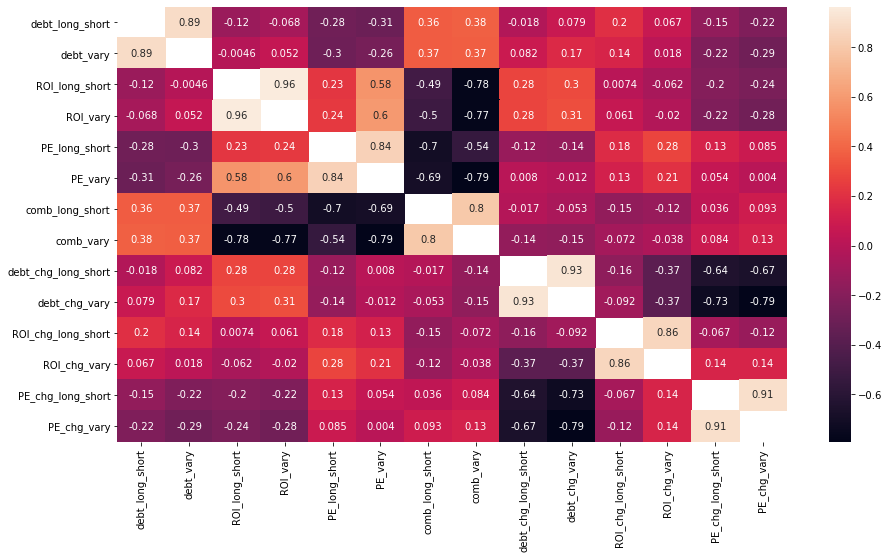

In [150]:
corr = display_corr(all_strat)
corr

Through the correlation matrix, we see that our signals all had a very low correlation with other strategies or even negative correlation with the other strategies. Therefore, we can conclude that each signal are independent and generate a different set of returns.

## Fama-French Factor analysis

In [151]:
# Regression ratio stats with a benchmark
def regression_stats(returns, market_return, annualization=1):
    
    stats = pd.DataFrame(index=returns.columns)
    
    X = sm.add_constant(market_return) # add a const to X data
    
    for fund in stats.index:
        y = returns[fund]
        results = sm.OLS(y, X, missing='drop').fit()
        alpha = results.params[0]
        beta = results.params[1]
        stats.loc[fund, 'Alpha'] = alpha * annualization
        stats.loc[fund, 'Market Beta'] = beta
        stats.loc[fund, 'Treynor Ratio'] = (y.mean() / beta) * annualization
        stats.loc[fund, 'Information Ratio'] = (alpha / results.resid.std()) * np.sqrt(annualization)
    
    return stats

# Regression statistics with the Fama French factors
def FF_regression(returns, factors, annualization=12):
    X = sm.add_constant(factors)
    
    stats = []
    
    for fund in returns.columns:
        y = returns[fund]
        results = sm.OLS(y, X, missing='drop').fit()
        params = results.params.to_frame(fund).T
        stats.append(params)
        params['r-squared'] = results.rsquared
        
    return pd.concat(stats)

In [152]:
# Import the Fama French factors
FF_df = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows = 3)
FF_df.dropna(inplace=True)
FF_df.rename(columns={'Unnamed: 0':'date'}, inplace=True)

FF_df['date'] = pd.to_datetime(FF_df['date'], format='%Y%m%d')
FF_df.set_index('date', inplace = True)
FF_df.sort_index(inplace=True)

FF_df = FF_df.loc[FF_df.index.isin(all_strat.index)] 
FF_df = FF_df / 100
FF_cum_ret = (1+FF_df).cumprod()

Text(0, 0.5, 'Cumulative Return')

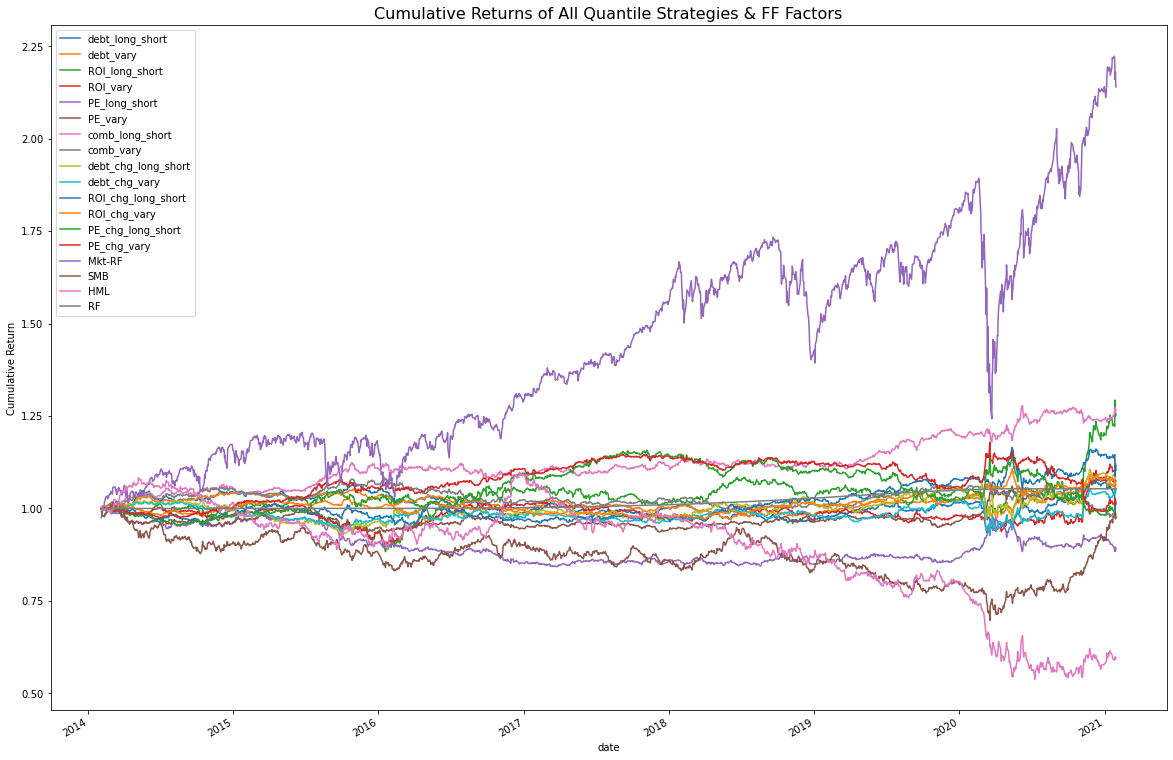

In [153]:
pd.merge(all_strat_cum_ret, FF_cum_ret, left_index=True, right_index=True).plot(figsize=(20, 14))
plt.title('Cumulative Returns of All Quantile Strategies & FF Factors', size=16)
plt.ylabel('Cumulative Return')

By plotting the Fama French factors and our strategy returns, we see that our strategy is much less volatile than the market. Given that it is a long short strategy, we are able to hedge away a lot of our market risk. Therefore, the cumulative returns have much less volatility. Our strategies are also able to return better than the HML and SMB factors, which indicates that our signal provides stronger returns.

In [154]:
FF_reg = FF_regression(all_strat, FF_df[['Mkt-RF', 'SMB', 'HML']], annualization=252)
FF_reg

const    Mkt-RF       SMB       HML  r-squared
debt_long_short      0.000025  0.038152 -0.115142  0.121865   0.159262
debt_vary            0.000055  0.010317 -0.081532  0.103846   0.184124
ROI_long_short       0.000164  0.068428  0.343136  0.204707   0.327169
ROI_vary             0.000089  0.038713  0.222631  0.150025   0.327360
PE_long_short       -0.000111  0.014848 -0.001426 -0.150998   0.137572
PE_vary              0.000018  0.012175  0.070698 -0.074062   0.081447
comb_long_short      0.000161 -0.020027 -0.077534  0.031861   0.040823
comb_vary            0.000013 -0.038967 -0.153136 -0.005046   0.205339
debt_chg_long_short  0.000109 -0.010128  0.063297  0.113663   0.068787
debt_chg_vary        0.000069 -0.004539  0.061456  0.118654   0.109333
ROI_chg_long_short   0.000044  0.026345 -0.044513 -0.019694   0.014592
ROI_chg_vary         0.000024  0.004407 -0.054462 -0.045570   0.050586
PE_chg_long_short   -0.000046  0.004452 -0.047191 -0.136779   0.087926
PE_chg_vary         -0.000015 -0.006638 -0.043287 -0.119842   0.105447

By running a regression of our strategy returns with the Fama French factors, we can see that it is difficult to replicate/explain most of our returns using just these factors. Most of the factor coefficients are small alongside the r-squared. The strategy with the highest r-squared is the ROI strategy, which seems to be explained by SMB and HML. In addition, as P/E can be considered an indicator of whether the stock is value or growth, being able to replicate this strategy with those 2 factors can be expected. Moreover, the ROI signal has a high r-squared and can be replicated by shorting the SMB and HML factors. Most of our strategies have a slight alpha, meaning they will perform better than trying to replicate it with the 3 factors.

In [155]:
market_reg = regression_stats(all_strat, FF_df['Mkt-RF'], annualization=252)
market_reg

Alpha  Market Beta  Treynor Ratio  Information Ratio
debt_long_short     -0.002532     0.041370       0.066826          -0.052186
debt_vary            0.006217     0.014130       0.568009           0.179806
ROI_long_short       0.022729     0.108453       0.337598           0.287191
ROI_vary             0.009004     0.066185       0.264072           0.168698
PE_long_short       -0.016101     0.001563     -10.171594          -0.314831
PE_vary              0.009893     0.010266       1.091655           0.252480
comb_long_short      0.038651    -0.022246      -1.609395           0.873374
comb_vary            0.004802    -0.049289       0.030589           0.132842
debt_chg_long_short  0.018130     0.003887       4.792616           0.300786
debt_chg_vary        0.007601     0.009794       0.904092           0.153322
ROI_chg_long_short   0.013014     0.021753       0.726279           0.248846
ROI_chg_vary         0.010067    -0.003088      -3.131350           0.286196
PE_chg_long_short   -0.000465    -0.010544       0.172163          -0.007626
PE_chg_vary          0.006000    -0.019902      -0.173436           0.120319

From the regression against the market benchmark, a majority of our strategies have a very low market beta and a decent alpha. Therefore, these strategies were able to deliver returns that are unexplained by the market. Our Treynor Ratio and Information Ratio for all the strategies are mediocore, making them slightly unattractive. However, their low correlation with the market offers good diversification benefits.

In [159]:
combined_FF = pd.merge(all_strat, FF_df, left_index=True, right_index=True)
FF_corr = combined_FF.corr()
FF_corr[['Mkt-RF', 'SMB', 'HML']]

Mkt-RF       SMB       HML
debt_long_short      0.152389 -0.177766  0.314121
debt_vary            0.073692 -0.183927  0.368129
ROI_long_short       0.240509  0.439454  0.368199
ROI_vary             0.218777  0.425842  0.393551
PE_long_short        0.005527 -0.025918 -0.367266
PE_vary              0.047322  0.157175 -0.218413
comb_long_short     -0.090521 -0.166748  0.067477
comb_vary           -0.239360 -0.411148 -0.071605
debt_chg_long_short  0.011659  0.113891  0.242691
debt_chg_vary        0.035700  0.138463  0.309920
ROI_chg_long_short   0.074999 -0.072225 -0.042545
ROI_chg_vary        -0.015875 -0.155672 -0.172703
PE_chg_long_short   -0.031225 -0.093582 -0.287642
PE_chg_vary         -0.071980 -0.108512 -0.312830
Mkt-RF               1.000000  0.124220  0.124843
SMB                  0.124220  1.000000  0.079816
HML                  0.124843  0.079816  1.000000
RF                  -0.026807 -0.035643 -0.030778

Our correlation with the market, SMB, and HML factors all remain quite low. Our highest correlation is our ROI strategy at 0.24 with market, 0.44 for SMB, and 0.37 HML. As this is our best performing strategy, it can be expected to have a higher correlation with these factors. For the other strategies, our returns did not depend on having a lot of exposure to long the market or any of the other factors, so the resulting correlation is low.